# Sarcasm Detection
 **Acknowledgement**

Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

## Install `Tensorflow2.0` 

In [1]:
#!!pip uninstall tensorflow
#!pip install tensorflow==2.0.0

## Get Required Files from Drive

In [2]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [3]:
#Set your project path 
#project_path =  ## Add your path here ##

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## 1 .Reading and Exploring Data**

## Read Data "Sarcasm_Headlines_Dataset.json". Explore the data and get  some insights about the data. ( 4 marks)
Hint - As its in json format you need to use pandas.read_json function. Give paraemeter lines = True.

In [5]:
Sarcasm_df=pd.read_json(path_or_buf='Sarcasm_Headlines_Dataset.json', orient=None, typ='frame', dtype=None, convert_axes=None, convert_dates=True, keep_default_dates=True, numpy=False, precise_float=False, date_unit=None, encoding=None, lines=True, chunksize=None, compression='infer')

In [6]:
Sarcasm_df

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [7]:
Sarcasm_df.count()

article_link    26709
headline        26709
is_sarcastic    26709
dtype: int64

In [8]:
Sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
article_link    26709 non-null object
headline        26709 non-null object
is_sarcastic    26709 non-null int64
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [9]:
Sarcasm_df.headline.value_counts()

sunday roundup                                                                  10
the 20 funniest tweets from women this week                                     10
'no way to prevent this,' says only nation where this regularly happens          8
the funniest tweets from parents this week                                       6
the funniest tweets from women this week                                         4
                                                                                ..
holocaust film appeals to believers and skeptics alike                           1
hellmann's heir's conduct unbefitting a mayonnaise magnate                       1
trump boys sadly release pet alligator into lincoln memorial reflecting pool     1
movie not nearly as awful as hoped                                               1
yep, 'the walking dead' is getting a seventh season                              1
Name: headline, Length: 26602, dtype: int64

In [10]:
Sarcasm_df.is_sarcastic.value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

### The scarcasm dataframe seems to have repetetive headlines and the dataset seems to be fairly balanced for both classes.

## 2. Drop one column

## Drop `article_link` from dataset. ( 2 marks)
As we only need headline text data and is_sarcastic column for this project. We can drop artical link column here.

In [11]:
Sarcasm_df.drop('article_link',axis=1,inplace=True)

In [12]:
Sarcasm_df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


## Text preprocessing

In [13]:
import re
import unicodedata

In [14]:
def remove_accented_chars(text):
    normalized_corpus = []
    
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [15]:
def remove_special_characters(text, remove_digits=False):
    #Using regex
     pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
     text = re.sub(pattern, '', text)
     return text

In [16]:
def normalize_corpus(corpus, accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
         # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
                # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [17]:
Sarcasm_df['headline']=normalize_corpus((Sarcasm_df['headline']))

In [18]:
Sarcasm_df['headline'].value_counts()

the funniest tweets from women this week                                                                    15
sunday roundup                                                                                              10
no way to prevent this says only nation where this regularly happens                                         8
huffpost rise what you need to know on february                                                              6
the funniest tweets from parents this week                                                                   6
                                                                                                            ..
brandy norwood i stopped believing in god lost my faith i was depressed                                      1
pregnancy isnt always pretty                                                                                 1
mark zuckerberg you should be grateful all your incessant oversharing online is actually worth something     1
p

## 3. Get length of each sentence

## Get the Length of each line and find the maximum length. ( 4 marks)
As different lines are of different length. We need to pad the our sequences using the max length.

In [19]:
count=len(Sarcasm_df)
linelen=[]
for i in range (0,count):
    llen=len(Sarcasm_df.headline[i])
    print(i)
    print("Length of",i,"th line",llen)
    linelen.append(llen)

0
Length of 0 th line 76
1
Length of 1 th line 81
2
Length of 2 th line 78
3
Length of 3 th line 82
4
Length of 4 th line 63
5
Length of 5 th line 26
6
Length of 6 th line 45
7
Length of 7 th line 66
8
Length of 8 th line 50
9
Length of 9 th line 56
10
Length of 10 th line 63
11
Length of 11 th line 59
12
Length of 12 th line 68
13
Length of 13 th line 60
14
Length of 14 th line 51
15
Length of 15 th line 61
16
Length of 16 th line 87
17
Length of 17 th line 49
18
Length of 18 th line 57
19
Length of 19 th line 20
20
Length of 20 th line 50
21
Length of 21 th line 111
22
Length of 22 th line 66
23
Length of 23 th line 41
24
Length of 24 th line 68
25
Length of 25 th line 37
26
Length of 26 th line 58
27
Length of 27 th line 21
28
Length of 28 th line 56
29
Length of 29 th line 40
30
Length of 30 th line 54
31
Length of 31 th line 50
32
Length of 32 th line 63
33
Length of 33 th line 59
34
Length of 34 th line 61
35
Length of 35 th line 34
36
Length of 36 th line 33
37
Length of 37 th l

Length of 440 th line 51
441
Length of 441 th line 56
442
Length of 442 th line 43
443
Length of 443 th line 66
444
Length of 444 th line 61
445
Length of 445 th line 74
446
Length of 446 th line 113
447
Length of 447 th line 60
448
Length of 448 th line 62
449
Length of 449 th line 91
450
Length of 450 th line 63
451
Length of 451 th line 62
452
Length of 452 th line 38
453
Length of 453 th line 23
454
Length of 454 th line 78
455
Length of 455 th line 88
456
Length of 456 th line 59
457
Length of 457 th line 78
458
Length of 458 th line 66
459
Length of 459 th line 37
460
Length of 460 th line 39
461
Length of 461 th line 70
462
Length of 462 th line 85
463
Length of 463 th line 55
464
Length of 464 th line 45
465
Length of 465 th line 28
466
Length of 466 th line 68
467
Length of 467 th line 72
468
Length of 468 th line 72
469
Length of 469 th line 62
470
Length of 470 th line 55
471
Length of 471 th line 55
472
Length of 472 th line 33
473
Length of 473 th line 93
474
Length of 474

Length of 794 th line 57
795
Length of 795 th line 74
796
Length of 796 th line 82
797
Length of 797 th line 62
798
Length of 798 th line 68
799
Length of 799 th line 57
800
Length of 800 th line 77
801
Length of 801 th line 88
802
Length of 802 th line 68
803
Length of 803 th line 62
804
Length of 804 th line 80
805
Length of 805 th line 86
806
Length of 806 th line 60
807
Length of 807 th line 55
808
Length of 808 th line 39
809
Length of 809 th line 67
810
Length of 810 th line 58
811
Length of 811 th line 80
812
Length of 812 th line 45
813
Length of 813 th line 47
814
Length of 814 th line 84
815
Length of 815 th line 31
816
Length of 816 th line 48
817
Length of 817 th line 89
818
Length of 818 th line 67
819
Length of 819 th line 83
820
Length of 820 th line 66
821
Length of 821 th line 60
822
Length of 822 th line 59
823
Length of 823 th line 39
824
Length of 824 th line 72
825
Length of 825 th line 59
826
Length of 826 th line 24
827
Length of 827 th line 43
828
Length of 828 

1087
Length of 1087 th line 59
1088
Length of 1088 th line 65
1089
Length of 1089 th line 48
1090
Length of 1090 th line 36
1091
Length of 1091 th line 50
1092
Length of 1092 th line 49
1093
Length of 1093 th line 50
1094
Length of 1094 th line 70
1095
Length of 1095 th line 78
1096
Length of 1096 th line 46
1097
Length of 1097 th line 66
1098
Length of 1098 th line 41
1099
Length of 1099 th line 64
1100
Length of 1100 th line 51
1101
Length of 1101 th line 100
1102
Length of 1102 th line 68
1103
Length of 1103 th line 65
1104
Length of 1104 th line 57
1105
Length of 1105 th line 51
1106
Length of 1106 th line 46
1107
Length of 1107 th line 55
1108
Length of 1108 th line 77
1109
Length of 1109 th line 55
1110
Length of 1110 th line 58
1111
Length of 1111 th line 26
1112
Length of 1112 th line 39
1113
Length of 1113 th line 60
1114
Length of 1114 th line 59
1115
Length of 1115 th line 72
1116
Length of 1116 th line 66
1117
Length of 1117 th line 62
1118
Length of 1118 th line 80
1119
Le

Length of 1362 th line 49
1363
Length of 1363 th line 57
1364
Length of 1364 th line 47
1365
Length of 1365 th line 34
1366
Length of 1366 th line 62
1367
Length of 1367 th line 35
1368
Length of 1368 th line 67
1369
Length of 1369 th line 68
1370
Length of 1370 th line 53
1371
Length of 1371 th line 69
1372
Length of 1372 th line 50
1373
Length of 1373 th line 41
1374
Length of 1374 th line 83
1375
Length of 1375 th line 39
1376
Length of 1376 th line 71
1377
Length of 1377 th line 74
1378
Length of 1378 th line 12
1379
Length of 1379 th line 85
1380
Length of 1380 th line 44
1381
Length of 1381 th line 75
1382
Length of 1382 th line 63
1383
Length of 1383 th line 84
1384
Length of 1384 th line 34
1385
Length of 1385 th line 57
1386
Length of 1386 th line 29
1387
Length of 1387 th line 66
1388
Length of 1388 th line 34
1389
Length of 1389 th line 83
1390
Length of 1390 th line 39
1391
Length of 1391 th line 86
1392
Length of 1392 th line 63
1393
Length of 1393 th line 67
1394
Length o

Length of 1631 th line 23
1632
Length of 1632 th line 72
1633
Length of 1633 th line 51
1634
Length of 1634 th line 54
1635
Length of 1635 th line 44
1636
Length of 1636 th line 31
1637
Length of 1637 th line 56
1638
Length of 1638 th line 46
1639
Length of 1639 th line 69
1640
Length of 1640 th line 42
1641
Length of 1641 th line 82
1642
Length of 1642 th line 61
1643
Length of 1643 th line 69
1644
Length of 1644 th line 33
1645
Length of 1645 th line 88
1646
Length of 1646 th line 59
1647
Length of 1647 th line 66
1648
Length of 1648 th line 59
1649
Length of 1649 th line 47
1650
Length of 1650 th line 63
1651
Length of 1651 th line 74
1652
Length of 1652 th line 65
1653
Length of 1653 th line 59
1654
Length of 1654 th line 82
1655
Length of 1655 th line 61
1656
Length of 1656 th line 49
1657
Length of 1657 th line 65
1658
Length of 1658 th line 98
1659
Length of 1659 th line 47
1660
Length of 1660 th line 53
1661
Length of 1661 th line 110
1662
Length of 1662 th line 45
1663
Length 

Length of 1895 th line 85
1896
Length of 1896 th line 62
1897
Length of 1897 th line 83
1898
Length of 1898 th line 23
1899
Length of 1899 th line 51
1900
Length of 1900 th line 46
1901
Length of 1901 th line 63
1902
Length of 1902 th line 46
1903
Length of 1903 th line 53
1904
Length of 1904 th line 53
1905
Length of 1905 th line 31
1906
Length of 1906 th line 43
1907
Length of 1907 th line 48
1908
Length of 1908 th line 94
1909
Length of 1909 th line 43
1910
Length of 1910 th line 85
1911
Length of 1911 th line 50
1912
Length of 1912 th line 44
1913
Length of 1913 th line 78
1914
Length of 1914 th line 94
1915
Length of 1915 th line 60
1916
Length of 1916 th line 56
1917
Length of 1917 th line 75
1918
Length of 1918 th line 63
1919
Length of 1919 th line 51
1920
Length of 1920 th line 43
1921
Length of 1921 th line 49
1922
Length of 1922 th line 55
1923
Length of 1923 th line 89
1924
Length of 1924 th line 64
1925
Length of 1925 th line 49
1926
Length of 1926 th line 65
1927
Length o

Length of 2214 th line 79
2215
Length of 2215 th line 66
2216
Length of 2216 th line 58
2217
Length of 2217 th line 67
2218
Length of 2218 th line 49
2219
Length of 2219 th line 68
2220
Length of 2220 th line 76
2221
Length of 2221 th line 48
2222
Length of 2222 th line 51
2223
Length of 2223 th line 75
2224
Length of 2224 th line 88
2225
Length of 2225 th line 44
2226
Length of 2226 th line 73
2227
Length of 2227 th line 69
2228
Length of 2228 th line 75
2229
Length of 2229 th line 77
2230
Length of 2230 th line 66
2231
Length of 2231 th line 76
2232
Length of 2232 th line 63
2233
Length of 2233 th line 28
2234
Length of 2234 th line 46
2235
Length of 2235 th line 67
2236
Length of 2236 th line 61
2237
Length of 2237 th line 53
2238
Length of 2238 th line 38
2239
Length of 2239 th line 52
2240
Length of 2240 th line 20
2241
Length of 2241 th line 18
2242
Length of 2242 th line 51
2243
Length of 2243 th line 43
2244
Length of 2244 th line 73
2245
Length of 2245 th line 77
2246
Length o

Length of 2504 th line 71
2505
Length of 2505 th line 37
2506
Length of 2506 th line 82
2507
Length of 2507 th line 73
2508
Length of 2508 th line 52
2509
Length of 2509 th line 52
2510
Length of 2510 th line 49
2511
Length of 2511 th line 48
2512
Length of 2512 th line 46
2513
Length of 2513 th line 75
2514
Length of 2514 th line 56
2515
Length of 2515 th line 85
2516
Length of 2516 th line 72
2517
Length of 2517 th line 56
2518
Length of 2518 th line 24
2519
Length of 2519 th line 24
2520
Length of 2520 th line 37
2521
Length of 2521 th line 45
2522
Length of 2522 th line 71
2523
Length of 2523 th line 65
2524
Length of 2524 th line 67
2525
Length of 2525 th line 51
2526
Length of 2526 th line 48
2527
Length of 2527 th line 60
2528
Length of 2528 th line 52
2529
Length of 2529 th line 65
2530
Length of 2530 th line 56
2531
Length of 2531 th line 61
2532
Length of 2532 th line 13
2533
Length of 2533 th line 26
2534
Length of 2534 th line 53
2535
Length of 2535 th line 43
2536
Length o

Length of 2801 th line 51
2802
Length of 2802 th line 45
2803
Length of 2803 th line 64
2804
Length of 2804 th line 45
2805
Length of 2805 th line 89
2806
Length of 2806 th line 82
2807
Length of 2807 th line 50
2808
Length of 2808 th line 61
2809
Length of 2809 th line 41
2810
Length of 2810 th line 51
2811
Length of 2811 th line 61
2812
Length of 2812 th line 69
2813
Length of 2813 th line 54
2814
Length of 2814 th line 40
2815
Length of 2815 th line 44
2816
Length of 2816 th line 45
2817
Length of 2817 th line 32
2818
Length of 2818 th line 126
2819
Length of 2819 th line 45
2820
Length of 2820 th line 84
2821
Length of 2821 th line 60
2822
Length of 2822 th line 46
2823
Length of 2823 th line 94
2824
Length of 2824 th line 60
2825
Length of 2825 th line 43
2826
Length of 2826 th line 37
2827
Length of 2827 th line 36
2828
Length of 2828 th line 67
2829
Length of 2829 th line 75
2830
Length of 2830 th line 45
2831
Length of 2831 th line 48
2832
Length of 2832 th line 42
2833
Length 

Length of 3086 th line 81
3087
Length of 3087 th line 39
3088
Length of 3088 th line 66
3089
Length of 3089 th line 43
3090
Length of 3090 th line 63
3091
Length of 3091 th line 49
3092
Length of 3092 th line 48
3093
Length of 3093 th line 43
3094
Length of 3094 th line 49
3095
Length of 3095 th line 85
3096
Length of 3096 th line 71
3097
Length of 3097 th line 41
3098
Length of 3098 th line 108
3099
Length of 3099 th line 59
3100
Length of 3100 th line 54
3101
Length of 3101 th line 57
3102
Length of 3102 th line 26
3103
Length of 3103 th line 67
3104
Length of 3104 th line 63
3105
Length of 3105 th line 43
3106
Length of 3106 th line 43
3107
Length of 3107 th line 24
3108
Length of 3108 th line 51
3109
Length of 3109 th line 38
3110
Length of 3110 th line 67
3111
Length of 3111 th line 63
3112
Length of 3112 th line 32
3113
Length of 3113 th line 102
3114
Length of 3114 th line 89
3115
Length of 3115 th line 61
3116
Length of 3116 th line 70
3117
Length of 3117 th line 56
3118
Length

Length of 3467 th line 32
3468
Length of 3468 th line 44
3469
Length of 3469 th line 73
3470
Length of 3470 th line 65
3471
Length of 3471 th line 60
3472
Length of 3472 th line 79
3473
Length of 3473 th line 55
3474
Length of 3474 th line 60
3475
Length of 3475 th line 56
3476
Length of 3476 th line 35
3477
Length of 3477 th line 77
3478
Length of 3478 th line 54
3479
Length of 3479 th line 104
3480
Length of 3480 th line 69
3481
Length of 3481 th line 49
3482
Length of 3482 th line 43
3483
Length of 3483 th line 27
3484
Length of 3484 th line 58
3485
Length of 3485 th line 47
3486
Length of 3486 th line 53
3487
Length of 3487 th line 62
3488
Length of 3488 th line 58
3489
Length of 3489 th line 93
3490
Length of 3490 th line 63
3491
Length of 3491 th line 69
3492
Length of 3492 th line 77
3493
Length of 3493 th line 90
3494
Length of 3494 th line 70
3495
Length of 3495 th line 65
3496
Length of 3496 th line 63
3497
Length of 3497 th line 80
3498
Length of 3498 th line 53
3499
Length 

Length of 3745 th line 71
3746
Length of 3746 th line 58
3747
Length of 3747 th line 40
3748
Length of 3748 th line 55
3749
Length of 3749 th line 67
3750
Length of 3750 th line 28
3751
Length of 3751 th line 55
3752
Length of 3752 th line 65
3753
Length of 3753 th line 50
3754
Length of 3754 th line 46
3755
Length of 3755 th line 58
3756
Length of 3756 th line 44
3757
Length of 3757 th line 56
3758
Length of 3758 th line 38
3759
Length of 3759 th line 74
3760
Length of 3760 th line 68
3761
Length of 3761 th line 78
3762
Length of 3762 th line 48
3763
Length of 3763 th line 40
3764
Length of 3764 th line 78
3765
Length of 3765 th line 102
3766
Length of 3766 th line 57
3767
Length of 3767 th line 50
3768
Length of 3768 th line 72
3769
Length of 3769 th line 69
3770
Length of 3770 th line 37
3771
Length of 3771 th line 33
3772
Length of 3772 th line 70
3773
Length of 3773 th line 107
3774
Length of 3774 th line 30
3775
Length of 3775 th line 54
3776
Length of 3776 th line 57
3777
Length

Length of 4094 th line 60
4095
Length of 4095 th line 57
4096
Length of 4096 th line 36
4097
Length of 4097 th line 52
4098
Length of 4098 th line 73
4099
Length of 4099 th line 29
4100
Length of 4100 th line 50
4101
Length of 4101 th line 47
4102
Length of 4102 th line 39
4103
Length of 4103 th line 34
4104
Length of 4104 th line 25
4105
Length of 4105 th line 58
4106
Length of 4106 th line 61
4107
Length of 4107 th line 32
4108
Length of 4108 th line 42
4109
Length of 4109 th line 44
4110
Length of 4110 th line 43
4111
Length of 4111 th line 48
4112
Length of 4112 th line 79
4113
Length of 4113 th line 29
4114
Length of 4114 th line 43
4115
Length of 4115 th line 39
4116
Length of 4116 th line 41
4117
Length of 4117 th line 79
4118
Length of 4118 th line 55
4119
Length of 4119 th line 16
4120
Length of 4120 th line 22
4121
Length of 4121 th line 35
4122
Length of 4122 th line 61
4123
Length of 4123 th line 42
4124
Length of 4124 th line 65
4125
Length of 4125 th line 72
4126
Length o

Length of 4395 th line 47
4396
Length of 4396 th line 54
4397
Length of 4397 th line 60
4398
Length of 4398 th line 18
4399
Length of 4399 th line 60
4400
Length of 4400 th line 66
4401
Length of 4401 th line 57
4402
Length of 4402 th line 47
4403
Length of 4403 th line 60
4404
Length of 4404 th line 54
4405
Length of 4405 th line 67
4406
Length of 4406 th line 57
4407
Length of 4407 th line 62
4408
Length of 4408 th line 68
4409
Length of 4409 th line 80
4410
Length of 4410 th line 49
4411
Length of 4411 th line 42
4412
Length of 4412 th line 49
4413
Length of 4413 th line 53
4414
Length of 4414 th line 79
4415
Length of 4415 th line 64
4416
Length of 4416 th line 63
4417
Length of 4417 th line 36
4418
Length of 4418 th line 55
4419
Length of 4419 th line 53
4420
Length of 4420 th line 41
4421
Length of 4421 th line 74
4422
Length of 4422 th line 35
4423
Length of 4423 th line 45
4424
Length of 4424 th line 67
4425
Length of 4425 th line 73
4426
Length of 4426 th line 37
4427
Length o

Length of 4930 th line 57
4931
Length of 4931 th line 61
4932
Length of 4932 th line 57
4933
Length of 4933 th line 81
4934
Length of 4934 th line 27
4935
Length of 4935 th line 83
4936
Length of 4936 th line 55
4937
Length of 4937 th line 60
4938
Length of 4938 th line 54
4939
Length of 4939 th line 68
4940
Length of 4940 th line 39
4941
Length of 4941 th line 71
4942
Length of 4942 th line 78
4943
Length of 4943 th line 47
4944
Length of 4944 th line 89
4945
Length of 4945 th line 62
4946
Length of 4946 th line 41
4947
Length of 4947 th line 46
4948
Length of 4948 th line 61
4949
Length of 4949 th line 56
4950
Length of 4950 th line 19
4951
Length of 4951 th line 63
4952
Length of 4952 th line 46
4953
Length of 4953 th line 71
4954
Length of 4954 th line 77
4955
Length of 4955 th line 50
4956
Length of 4956 th line 45
4957
Length of 4957 th line 76
4958
Length of 4958 th line 62
4959
Length of 4959 th line 71
4960
Length of 4960 th line 79
4961
Length of 4961 th line 65
4962
Length o

Length of 5202 th line 59
5203
Length of 5203 th line 63
5204
Length of 5204 th line 65
5205
Length of 5205 th line 39
5206
Length of 5206 th line 71
5207
Length of 5207 th line 55
5208
Length of 5208 th line 27
5209
Length of 5209 th line 80
5210
Length of 5210 th line 29
5211
Length of 5211 th line 74
5212
Length of 5212 th line 44
5213
Length of 5213 th line 50
5214
Length of 5214 th line 48
5215
Length of 5215 th line 56
5216
Length of 5216 th line 59
5217
Length of 5217 th line 83
5218
Length of 5218 th line 104
5219
Length of 5219 th line 35
5220
Length of 5220 th line 86
5221
Length of 5221 th line 56
5222
Length of 5222 th line 51
5223
Length of 5223 th line 67
5224
Length of 5224 th line 57
5225
Length of 5225 th line 84
5226
Length of 5226 th line 48
5227
Length of 5227 th line 24
5228
Length of 5228 th line 32
5229
Length of 5229 th line 113
5230
Length of 5230 th line 31
5231
Length of 5231 th line 66
5232
Length of 5232 th line 48
5233
Length of 5233 th line 67
5234
Length

Length of 5547 th line 24
5548
Length of 5548 th line 46
5549
Length of 5549 th line 24
5550
Length of 5550 th line 42
5551
Length of 5551 th line 68
5552
Length of 5552 th line 50
5553
Length of 5553 th line 57
5554
Length of 5554 th line 47
5555
Length of 5555 th line 51
5556
Length of 5556 th line 70
5557
Length of 5557 th line 45
5558
Length of 5558 th line 112
5559
Length of 5559 th line 85
5560
Length of 5560 th line 67
5561
Length of 5561 th line 65
5562
Length of 5562 th line 67
5563
Length of 5563 th line 45
5564
Length of 5564 th line 37
5565
Length of 5565 th line 58
5566
Length of 5566 th line 33
5567
Length of 5567 th line 78
5568
Length of 5568 th line 47
5569
Length of 5569 th line 52
5570
Length of 5570 th line 41
5571
Length of 5571 th line 45
5572
Length of 5572 th line 63
5573
Length of 5573 th line 65
5574
Length of 5574 th line 86
5575
Length of 5575 th line 72
5576
Length of 5576 th line 74
5577
Length of 5577 th line 54
5578
Length of 5578 th line 90
5579
Length 

Length of 5812 th line 137
5813
Length of 5813 th line 73
5814
Length of 5814 th line 64
5815
Length of 5815 th line 27
5816
Length of 5816 th line 73
5817
Length of 5817 th line 65
5818
Length of 5818 th line 20
5819
Length of 5819 th line 35
5820
Length of 5820 th line 45
5821
Length of 5821 th line 56
5822
Length of 5822 th line 71
5823
Length of 5823 th line 52
5824
Length of 5824 th line 89
5825
Length of 5825 th line 94
5826
Length of 5826 th line 44
5827
Length of 5827 th line 73
5828
Length of 5828 th line 45
5829
Length of 5829 th line 47
5830
Length of 5830 th line 49
5831
Length of 5831 th line 38
5832
Length of 5832 th line 98
5833
Length of 5833 th line 78
5834
Length of 5834 th line 41
5835
Length of 5835 th line 67
5836
Length of 5836 th line 55
5837
Length of 5837 th line 66
5838
Length of 5838 th line 46
5839
Length of 5839 th line 23
5840
Length of 5840 th line 113
5841
Length of 5841 th line 46
5842
Length of 5842 th line 130
5843
Length of 5843 th line 72
5844
Lengt

Length of 6100 th line 63
6101
Length of 6101 th line 69
6102
Length of 6102 th line 40
6103
Length of 6103 th line 36
6104
Length of 6104 th line 63
6105
Length of 6105 th line 73
6106
Length of 6106 th line 90
6107
Length of 6107 th line 63
6108
Length of 6108 th line 64
6109
Length of 6109 th line 39
6110
Length of 6110 th line 67
6111
Length of 6111 th line 78
6112
Length of 6112 th line 37
6113
Length of 6113 th line 78
6114
Length of 6114 th line 26
6115
Length of 6115 th line 70
6116
Length of 6116 th line 26
6117
Length of 6117 th line 66
6118
Length of 6118 th line 95
6119
Length of 6119 th line 48
6120
Length of 6120 th line 44
6121
Length of 6121 th line 33
6122
Length of 6122 th line 52
6123
Length of 6123 th line 71
6124
Length of 6124 th line 19
6125
Length of 6125 th line 47
6126
Length of 6126 th line 60
6127
Length of 6127 th line 37
6128
Length of 6128 th line 57
6129
Length of 6129 th line 84
6130
Length of 6130 th line 43
6131
Length of 6131 th line 52
6132
Length o

Length of 6380 th line 71
6381
Length of 6381 th line 81
6382
Length of 6382 th line 68
6383
Length of 6383 th line 14
6384
Length of 6384 th line 81
6385
Length of 6385 th line 61
6386
Length of 6386 th line 71
6387
Length of 6387 th line 32
6388
Length of 6388 th line 94
6389
Length of 6389 th line 80
6390
Length of 6390 th line 64
6391
Length of 6391 th line 28
6392
Length of 6392 th line 62
6393
Length of 6393 th line 66
6394
Length of 6394 th line 24
6395
Length of 6395 th line 40
6396
Length of 6396 th line 59
6397
Length of 6397 th line 64
6398
Length of 6398 th line 41
6399
Length of 6399 th line 39
6400
Length of 6400 th line 77
6401
Length of 6401 th line 74
6402
Length of 6402 th line 39
6403
Length of 6403 th line 27
6404
Length of 6404 th line 37
6405
Length of 6405 th line 73
6406
Length of 6406 th line 32
6407
Length of 6407 th line 58
6408
Length of 6408 th line 67
6409
Length of 6409 th line 62
6410
Length of 6410 th line 66
6411
Length of 6411 th line 78
6412
Length o

Length of 6679 th line 27
6680
Length of 6680 th line 59
6681
Length of 6681 th line 64
6682
Length of 6682 th line 90
6683
Length of 6683 th line 69
6684
Length of 6684 th line 20
6685
Length of 6685 th line 33
6686
Length of 6686 th line 29
6687
Length of 6687 th line 80
6688
Length of 6688 th line 64
6689
Length of 6689 th line 54
6690
Length of 6690 th line 58
6691
Length of 6691 th line 53
6692
Length of 6692 th line 79
6693
Length of 6693 th line 36
6694
Length of 6694 th line 74
6695
Length of 6695 th line 61
6696
Length of 6696 th line 76
6697
Length of 6697 th line 85
6698
Length of 6698 th line 68
6699
Length of 6699 th line 44
6700
Length of 6700 th line 42
6701
Length of 6701 th line 48
6702
Length of 6702 th line 53
6703
Length of 6703 th line 39
6704
Length of 6704 th line 94
6705
Length of 6705 th line 42
6706
Length of 6706 th line 65
6707
Length of 6707 th line 29
6708
Length of 6708 th line 42
6709
Length of 6709 th line 66
6710
Length of 6710 th line 65
6711
Length o

7026
Length of 7026 th line 67
7027
Length of 7027 th line 48
7028
Length of 7028 th line 64
7029
Length of 7029 th line 78
7030
Length of 7030 th line 44
7031
Length of 7031 th line 81
7032
Length of 7032 th line 64
7033
Length of 7033 th line 44
7034
Length of 7034 th line 71
7035
Length of 7035 th line 49
7036
Length of 7036 th line 75
7037
Length of 7037 th line 59
7038
Length of 7038 th line 47
7039
Length of 7039 th line 26
7040
Length of 7040 th line 68
7041
Length of 7041 th line 37
7042
Length of 7042 th line 35
7043
Length of 7043 th line 108
7044
Length of 7044 th line 50
7045
Length of 7045 th line 51
7046
Length of 7046 th line 56
7047
Length of 7047 th line 43
7048
Length of 7048 th line 84
7049
Length of 7049 th line 37
7050
Length of 7050 th line 86
7051
Length of 7051 th line 24
7052
Length of 7052 th line 45
7053
Length of 7053 th line 67
7054
Length of 7054 th line 58
7055
Length of 7055 th line 39
7056
Length of 7056 th line 39
7057
Length of 7057 th line 79
7058
Le

Length of 7297 th line 38
7298
Length of 7298 th line 73
7299
Length of 7299 th line 48
7300
Length of 7300 th line 59
7301
Length of 7301 th line 64
7302
Length of 7302 th line 66
7303
Length of 7303 th line 62
7304
Length of 7304 th line 62
7305
Length of 7305 th line 24
7306
Length of 7306 th line 73
7307
Length of 7307 th line 53
7308
Length of 7308 th line 65
7309
Length of 7309 th line 50
7310
Length of 7310 th line 69
7311
Length of 7311 th line 108
7312
Length of 7312 th line 64
7313
Length of 7313 th line 68
7314
Length of 7314 th line 42
7315
Length of 7315 th line 11
7316
Length of 7316 th line 59
7317
Length of 7317 th line 59
7318
Length of 7318 th line 64
7319
Length of 7319 th line 41
7320
Length of 7320 th line 91
7321
Length of 7321 th line 43
7322
Length of 7322 th line 66
7323
Length of 7323 th line 100
7324
Length of 7324 th line 66
7325
Length of 7325 th line 49
7326
Length of 7326 th line 34
7327
Length of 7327 th line 66
7328
Length of 7328 th line 77
7329
Length

Length of 7565 th line 61
7566
Length of 7566 th line 65
7567
Length of 7567 th line 65
7568
Length of 7568 th line 72
7569
Length of 7569 th line 34
7570
Length of 7570 th line 52
7571
Length of 7571 th line 49
7572
Length of 7572 th line 61
7573
Length of 7573 th line 62
7574
Length of 7574 th line 26
7575
Length of 7575 th line 49
7576
Length of 7576 th line 36
7577
Length of 7577 th line 65
7578
Length of 7578 th line 61
7579
Length of 7579 th line 52
7580
Length of 7580 th line 109
7581
Length of 7581 th line 84
7582
Length of 7582 th line 40
7583
Length of 7583 th line 61
7584
Length of 7584 th line 86
7585
Length of 7585 th line 69
7586
Length of 7586 th line 58
7587
Length of 7587 th line 64
7588
Length of 7588 th line 83
7589
Length of 7589 th line 32
7590
Length of 7590 th line 68
7591
Length of 7591 th line 47
7592
Length of 7592 th line 40
7593
Length of 7593 th line 45
7594
Length of 7594 th line 61
7595
Length of 7595 th line 58
7596
Length of 7596 th line 67
7597
Length 

Length of 7841 th line 87
7842
Length of 7842 th line 63
7843
Length of 7843 th line 51
7844
Length of 7844 th line 68
7845
Length of 7845 th line 47
7846
Length of 7846 th line 55
7847
Length of 7847 th line 34
7848
Length of 7848 th line 31
7849
Length of 7849 th line 74
7850
Length of 7850 th line 57
7851
Length of 7851 th line 67
7852
Length of 7852 th line 81
7853
Length of 7853 th line 54
7854
Length of 7854 th line 67
7855
Length of 7855 th line 72
7856
Length of 7856 th line 45
7857
Length of 7857 th line 50
7858
Length of 7858 th line 62
7859
Length of 7859 th line 36
7860
Length of 7860 th line 56
7861
Length of 7861 th line 35
7862
Length of 7862 th line 69
7863
Length of 7863 th line 54
7864
Length of 7864 th line 64
7865
Length of 7865 th line 58
7866
Length of 7866 th line 80
7867
Length of 7867 th line 54
7868
Length of 7868 th line 34
7869
Length of 7869 th line 55
7870
Length of 7870 th line 67
7871
Length of 7871 th line 59
7872
Length of 7872 th line 55
7873
Length o

Length of 8155 th line 71
8156
Length of 8156 th line 34
8157
Length of 8157 th line 38
8158
Length of 8158 th line 38
8159
Length of 8159 th line 29
8160
Length of 8160 th line 90
8161
Length of 8161 th line 75
8162
Length of 8162 th line 67
8163
Length of 8163 th line 41
8164
Length of 8164 th line 40
8165
Length of 8165 th line 68
8166
Length of 8166 th line 60
8167
Length of 8167 th line 50
8168
Length of 8168 th line 54
8169
Length of 8169 th line 56
8170
Length of 8170 th line 52
8171
Length of 8171 th line 53
8172
Length of 8172 th line 36
8173
Length of 8173 th line 50
8174
Length of 8174 th line 83
8175
Length of 8175 th line 71
8176
Length of 8176 th line 69
8177
Length of 8177 th line 47
8178
Length of 8178 th line 54
8179
Length of 8179 th line 67
8180
Length of 8180 th line 56
8181
Length of 8181 th line 54
8182
Length of 8182 th line 48
8183
Length of 8183 th line 58
8184
Length of 8184 th line 57
8185
Length of 8185 th line 56
8186
Length of 8186 th line 74
8187
Length o

Length of 8582 th line 47
8583
Length of 8583 th line 66
8584
Length of 8584 th line 77
8585
Length of 8585 th line 50
8586
Length of 8586 th line 45
8587
Length of 8587 th line 65
8588
Length of 8588 th line 57
8589
Length of 8589 th line 79
8590
Length of 8590 th line 46
8591
Length of 8591 th line 32
8592
Length of 8592 th line 44
8593
Length of 8593 th line 73
8594
Length of 8594 th line 48
8595
Length of 8595 th line 67
8596
Length of 8596 th line 100
8597
Length of 8597 th line 69
8598
Length of 8598 th line 60
8599
Length of 8599 th line 80
8600
Length of 8600 th line 68
8601
Length of 8601 th line 58
8602
Length of 8602 th line 81
8603
Length of 8603 th line 100
8604
Length of 8604 th line 61
8605
Length of 8605 th line 57
8606
Length of 8606 th line 73
8607
Length of 8607 th line 46
8608
Length of 8608 th line 71
8609
Length of 8609 th line 65
8610
Length of 8610 th line 59
8611
Length of 8611 th line 90
8612
Length of 8612 th line 40
8613
Length of 8613 th line 66
8614
Length

8984
Length of 8984 th line 66
8985
Length of 8985 th line 67
8986
Length of 8986 th line 63
8987
Length of 8987 th line 68
8988
Length of 8988 th line 49
8989
Length of 8989 th line 63
8990
Length of 8990 th line 76
8991
Length of 8991 th line 64
8992
Length of 8992 th line 56
8993
Length of 8993 th line 46
8994
Length of 8994 th line 67
8995
Length of 8995 th line 75
8996
Length of 8996 th line 85
8997
Length of 8997 th line 48
8998
Length of 8998 th line 64
8999
Length of 8999 th line 56
9000
Length of 9000 th line 45
9001
Length of 9001 th line 38
9002
Length of 9002 th line 63
9003
Length of 9003 th line 70
9004
Length of 9004 th line 65
9005
Length of 9005 th line 73
9006
Length of 9006 th line 51
9007
Length of 9007 th line 103
9008
Length of 9008 th line 58
9009
Length of 9009 th line 50
9010
Length of 9010 th line 81
9011
Length of 9011 th line 34
9012
Length of 9012 th line 58
9013
Length of 9013 th line 68
9014
Length of 9014 th line 90
9015
Length of 9015 th line 27
9016
Le

Length of 9264 th line 42
9265
Length of 9265 th line 63
9266
Length of 9266 th line 61
9267
Length of 9267 th line 89
9268
Length of 9268 th line 47
9269
Length of 9269 th line 58
9270
Length of 9270 th line 40
9271
Length of 9271 th line 35
9272
Length of 9272 th line 51
9273
Length of 9273 th line 50
9274
Length of 9274 th line 84
9275
Length of 9275 th line 65
9276
Length of 9276 th line 95
9277
Length of 9277 th line 40
9278
Length of 9278 th line 69
9279
Length of 9279 th line 39
9280
Length of 9280 th line 76
9281
Length of 9281 th line 54
9282
Length of 9282 th line 99
9283
Length of 9283 th line 42
9284
Length of 9284 th line 64
9285
Length of 9285 th line 65
9286
Length of 9286 th line 39
9287
Length of 9287 th line 37
9288
Length of 9288 th line 71
9289
Length of 9289 th line 47
9290
Length of 9290 th line 77
9291
Length of 9291 th line 76
9292
Length of 9292 th line 75
9293
Length of 9293 th line 37
9294
Length of 9294 th line 69
9295
Length of 9295 th line 75
9296
Length o

9551
Length of 9551 th line 42
9552
Length of 9552 th line 75
9553
Length of 9553 th line 50
9554
Length of 9554 th line 78
9555
Length of 9555 th line 43
9556
Length of 9556 th line 60
9557
Length of 9557 th line 46
9558
Length of 9558 th line 54
9559
Length of 9559 th line 56
9560
Length of 9560 th line 64
9561
Length of 9561 th line 70
9562
Length of 9562 th line 77
9563
Length of 9563 th line 69
9564
Length of 9564 th line 79
9565
Length of 9565 th line 79
9566
Length of 9566 th line 79
9567
Length of 9567 th line 74
9568
Length of 9568 th line 80
9569
Length of 9569 th line 42
9570
Length of 9570 th line 81
9571
Length of 9571 th line 64
9572
Length of 9572 th line 43
9573
Length of 9573 th line 44
9574
Length of 9574 th line 91
9575
Length of 9575 th line 28
9576
Length of 9576 th line 67
9577
Length of 9577 th line 67
9578
Length of 9578 th line 68
9579
Length of 9579 th line 94
9580
Length of 9580 th line 31
9581
Length of 9581 th line 61
9582
Length of 9582 th line 58
9583
Len

Length of 9842 th line 44
9843
Length of 9843 th line 110
9844
Length of 9844 th line 18
9845
Length of 9845 th line 72
9846
Length of 9846 th line 49
9847
Length of 9847 th line 56
9848
Length of 9848 th line 70
9849
Length of 9849 th line 59
9850
Length of 9850 th line 67
9851
Length of 9851 th line 87
9852
Length of 9852 th line 61
9853
Length of 9853 th line 47
9854
Length of 9854 th line 64
9855
Length of 9855 th line 55
9856
Length of 9856 th line 61
9857
Length of 9857 th line 58
9858
Length of 9858 th line 29
9859
Length of 9859 th line 55
9860
Length of 9860 th line 90
9861
Length of 9861 th line 52
9862
Length of 9862 th line 56
9863
Length of 9863 th line 86
9864
Length of 9864 th line 59
9865
Length of 9865 th line 64
9866
Length of 9866 th line 81
9867
Length of 9867 th line 88
9868
Length of 9868 th line 39
9869
Length of 9869 th line 51
9870
Length of 9870 th line 27
9871
Length of 9871 th line 23
9872
Length of 9872 th line 52
9873
Length of 9873 th line 38
9874
Length 

Length of 10125 th line 128
10126
Length of 10126 th line 47
10127
Length of 10127 th line 35
10128
Length of 10128 th line 56
10129
Length of 10129 th line 74
10130
Length of 10130 th line 83
10131
Length of 10131 th line 74
10132
Length of 10132 th line 79
10133
Length of 10133 th line 100
10134
Length of 10134 th line 57
10135
Length of 10135 th line 32
10136
Length of 10136 th line 69
10137
Length of 10137 th line 30
10138
Length of 10138 th line 69
10139
Length of 10139 th line 91
10140
Length of 10140 th line 77
10141
Length of 10141 th line 63
10142
Length of 10142 th line 74
10143
Length of 10143 th line 50
10144
Length of 10144 th line 66
10145
Length of 10145 th line 41
10146
Length of 10146 th line 72
10147
Length of 10147 th line 45
10148
Length of 10148 th line 39
10149
Length of 10149 th line 62
10150
Length of 10150 th line 42
10151
Length of 10151 th line 71
10152
Length of 10152 th line 28
10153
Length of 10153 th line 50
10154
Length of 10154 th line 59
10155
Length o

10466
Length of 10466 th line 95
10467
Length of 10467 th line 61
10468
Length of 10468 th line 86
10469
Length of 10469 th line 16
10470
Length of 10470 th line 16
10471
Length of 10471 th line 92
10472
Length of 10472 th line 48
10473
Length of 10473 th line 93
10474
Length of 10474 th line 51
10475
Length of 10475 th line 29
10476
Length of 10476 th line 45
10477
Length of 10477 th line 36
10478
Length of 10478 th line 52
10479
Length of 10479 th line 68
10480
Length of 10480 th line 30
10481
Length of 10481 th line 52
10482
Length of 10482 th line 68
10483
Length of 10483 th line 69
10484
Length of 10484 th line 75
10485
Length of 10485 th line 42
10486
Length of 10486 th line 49
10487
Length of 10487 th line 104
10488
Length of 10488 th line 51
10489
Length of 10489 th line 58
10490
Length of 10490 th line 86
10491
Length of 10491 th line 68
10492
Length of 10492 th line 64
10493
Length of 10493 th line 61
10494
Length of 10494 th line 88
10495
Length of 10495 th line 63
10496
Len

Length of 10826 th line 81
10827
Length of 10827 th line 61
10828
Length of 10828 th line 72
10829
Length of 10829 th line 67
10830
Length of 10830 th line 68
10831
Length of 10831 th line 66
10832
Length of 10832 th line 69
10833
Length of 10833 th line 59
10834
Length of 10834 th line 61
10835
Length of 10835 th line 68
10836
Length of 10836 th line 43
10837
Length of 10837 th line 75
10838
Length of 10838 th line 63
10839
Length of 10839 th line 56
10840
Length of 10840 th line 69
10841
Length of 10841 th line 99
10842
Length of 10842 th line 73
10843
Length of 10843 th line 78
10844
Length of 10844 th line 39
10845
Length of 10845 th line 69
10846
Length of 10846 th line 64
10847
Length of 10847 th line 63
10848
Length of 10848 th line 16
10849
Length of 10849 th line 82
10850
Length of 10850 th line 58
10851
Length of 10851 th line 75
10852
Length of 10852 th line 86
10853
Length of 10853 th line 24
10854
Length of 10854 th line 26
10855
Length of 10855 th line 55
10856
Length of 

Length of 11166 th line 79
11167
Length of 11167 th line 73
11168
Length of 11168 th line 31
11169
Length of 11169 th line 40
11170
Length of 11170 th line 60
11171
Length of 11171 th line 67
11172
Length of 11172 th line 58
11173
Length of 11173 th line 66
11174
Length of 11174 th line 97
11175
Length of 11175 th line 79
11176
Length of 11176 th line 68
11177
Length of 11177 th line 73
11178
Length of 11178 th line 58
11179
Length of 11179 th line 78
11180
Length of 11180 th line 70
11181
Length of 11181 th line 17
11182
Length of 11182 th line 48
11183
Length of 11183 th line 38
11184
Length of 11184 th line 87
11185
Length of 11185 th line 34
11186
Length of 11186 th line 59
11187
Length of 11187 th line 76
11188
Length of 11188 th line 42
11189
Length of 11189 th line 39
11190
Length of 11190 th line 58
11191
Length of 11191 th line 91
11192
Length of 11192 th line 67
11193
Length of 11193 th line 63
11194
Length of 11194 th line 45
11195
Length of 11195 th line 46
11196
Length of 

Length of 11512 th line 57
11513
Length of 11513 th line 70
11514
Length of 11514 th line 38
11515
Length of 11515 th line 54
11516
Length of 11516 th line 75
11517
Length of 11517 th line 42
11518
Length of 11518 th line 52
11519
Length of 11519 th line 52
11520
Length of 11520 th line 56
11521
Length of 11521 th line 53
11522
Length of 11522 th line 39
11523
Length of 11523 th line 13
11524
Length of 11524 th line 23
11525
Length of 11525 th line 42
11526
Length of 11526 th line 62
11527
Length of 11527 th line 64
11528
Length of 11528 th line 40
11529
Length of 11529 th line 75
11530
Length of 11530 th line 83
11531
Length of 11531 th line 49
11532
Length of 11532 th line 43
11533
Length of 11533 th line 70
11534
Length of 11534 th line 65
11535
Length of 11535 th line 44
11536
Length of 11536 th line 49
11537
Length of 11537 th line 77
11538
Length of 11538 th line 79
11539
Length of 11539 th line 92
11540
Length of 11540 th line 50
11541
Length of 11541 th line 84
11542
Length of 

Length of 11868 th line 22
11869
Length of 11869 th line 43
11870
Length of 11870 th line 52
11871
Length of 11871 th line 49
11872
Length of 11872 th line 96
11873
Length of 11873 th line 42
11874
Length of 11874 th line 56
11875
Length of 11875 th line 95
11876
Length of 11876 th line 75
11877
Length of 11877 th line 68
11878
Length of 11878 th line 56
11879
Length of 11879 th line 48
11880
Length of 11880 th line 21
11881
Length of 11881 th line 34
11882
Length of 11882 th line 67
11883
Length of 11883 th line 55
11884
Length of 11884 th line 70
11885
Length of 11885 th line 98
11886
Length of 11886 th line 67
11887
Length of 11887 th line 43
11888
Length of 11888 th line 73
11889
Length of 11889 th line 51
11890
Length of 11890 th line 43
11891
Length of 11891 th line 60
11892
Length of 11892 th line 72
11893
Length of 11893 th line 50
11894
Length of 11894 th line 68
11895
Length of 11895 th line 83
11896
Length of 11896 th line 70
11897
Length of 11897 th line 42
11898
Length of 

Length of 12302 th line 40
12303
Length of 12303 th line 58
12304
Length of 12304 th line 67
12305
Length of 12305 th line 54
12306
Length of 12306 th line 46
12307
Length of 12307 th line 23
12308
Length of 12308 th line 59
12309
Length of 12309 th line 53
12310
Length of 12310 th line 51
12311
Length of 12311 th line 36
12312
Length of 12312 th line 111
12313
Length of 12313 th line 61
12314
Length of 12314 th line 64
12315
Length of 12315 th line 62
12316
Length of 12316 th line 36
12317
Length of 12317 th line 65
12318
Length of 12318 th line 31
12319
Length of 12319 th line 62
12320
Length of 12320 th line 39
12321
Length of 12321 th line 40
12322
Length of 12322 th line 54
12323
Length of 12323 th line 89
12324
Length of 12324 th line 114
12325
Length of 12325 th line 50
12326
Length of 12326 th line 45
12327
Length of 12327 th line 62
12328
Length of 12328 th line 42
12329
Length of 12329 th line 45
12330
Length of 12330 th line 74
12331
Length of 12331 th line 51
12332
Length o

Length of 12683 th line 104
12684
Length of 12684 th line 63
12685
Length of 12685 th line 73
12686
Length of 12686 th line 42
12687
Length of 12687 th line 67
12688
Length of 12688 th line 66
12689
Length of 12689 th line 81
12690
Length of 12690 th line 73
12691
Length of 12691 th line 90
12692
Length of 12692 th line 66
12693
Length of 12693 th line 65
12694
Length of 12694 th line 50
12695
Length of 12695 th line 53
12696
Length of 12696 th line 57
12697
Length of 12697 th line 102
12698
Length of 12698 th line 51
12699
Length of 12699 th line 36
12700
Length of 12700 th line 56
12701
Length of 12701 th line 42
12702
Length of 12702 th line 40
12703
Length of 12703 th line 63
12704
Length of 12704 th line 71
12705
Length of 12705 th line 51
12706
Length of 12706 th line 76
12707
Length of 12707 th line 91
12708
Length of 12708 th line 38
12709
Length of 12709 th line 84
12710
Length of 12710 th line 55
12711
Length of 12711 th line 39
12712
Length of 12712 th line 45
12713
Length o

Length of 12956 th line 13
12957
Length of 12957 th line 53
12958
Length of 12958 th line 91
12959
Length of 12959 th line 78
12960
Length of 12960 th line 63
12961
Length of 12961 th line 70
12962
Length of 12962 th line 48
12963
Length of 12963 th line 39
12964
Length of 12964 th line 62
12965
Length of 12965 th line 46
12966
Length of 12966 th line 71
12967
Length of 12967 th line 77
12968
Length of 12968 th line 54
12969
Length of 12969 th line 87
12970
Length of 12970 th line 65
12971
Length of 12971 th line 51
12972
Length of 12972 th line 64
12973
Length of 12973 th line 38
12974
Length of 12974 th line 131
12975
Length of 12975 th line 86
12976
Length of 12976 th line 53
12977
Length of 12977 th line 38
12978
Length of 12978 th line 47
12979
Length of 12979 th line 52
12980
Length of 12980 th line 37
12981
Length of 12981 th line 55
12982
Length of 12982 th line 65
12983
Length of 12983 th line 83
12984
Length of 12984 th line 69
12985
Length of 12985 th line 27
12986
Length of

Length of 13283 th line 73
13284
Length of 13284 th line 71
13285
Length of 13285 th line 52
13286
Length of 13286 th line 80
13287
Length of 13287 th line 66
13288
Length of 13288 th line 79
13289
Length of 13289 th line 42
13290
Length of 13290 th line 59
13291
Length of 13291 th line 25
13292
Length of 13292 th line 57
13293
Length of 13293 th line 77
13294
Length of 13294 th line 56
13295
Length of 13295 th line 66
13296
Length of 13296 th line 59
13297
Length of 13297 th line 63
13298
Length of 13298 th line 85
13299
Length of 13299 th line 93
13300
Length of 13300 th line 72
13301
Length of 13301 th line 36
13302
Length of 13302 th line 70
13303
Length of 13303 th line 97
13304
Length of 13304 th line 55
13305
Length of 13305 th line 70
13306
Length of 13306 th line 49
13307
Length of 13307 th line 55
13308
Length of 13308 th line 25
13309
Length of 13309 th line 67
13310
Length of 13310 th line 54
13311
Length of 13311 th line 135
13312
Length of 13312 th line 55
13313
Length of

Length of 13547 th line 86
13548
Length of 13548 th line 61
13549
Length of 13549 th line 30
13550
Length of 13550 th line 69
13551
Length of 13551 th line 72
13552
Length of 13552 th line 50
13553
Length of 13553 th line 59
13554
Length of 13554 th line 71
13555
Length of 13555 th line 63
13556
Length of 13556 th line 71
13557
Length of 13557 th line 62
13558
Length of 13558 th line 72
13559
Length of 13559 th line 30
13560
Length of 13560 th line 63
13561
Length of 13561 th line 70
13562
Length of 13562 th line 66
13563
Length of 13563 th line 49
13564
Length of 13564 th line 41
13565
Length of 13565 th line 18
13566
Length of 13566 th line 52
13567
Length of 13567 th line 68
13568
Length of 13568 th line 66
13569
Length of 13569 th line 40
13570
Length of 13570 th line 43
13571
Length of 13571 th line 36
13572
Length of 13572 th line 46
13573
Length of 13573 th line 46
13574
Length of 13574 th line 52
13575
Length of 13575 th line 35
13576
Length of 13576 th line 63
13577
Length of 

Length of 13841 th line 72
13842
Length of 13842 th line 28
13843
Length of 13843 th line 62
13844
Length of 13844 th line 76
13845
Length of 13845 th line 73
13846
Length of 13846 th line 32
13847
Length of 13847 th line 53
13848
Length of 13848 th line 104
13849
Length of 13849 th line 62
13850
Length of 13850 th line 81
13851
Length of 13851 th line 82
13852
Length of 13852 th line 16
13853
Length of 13853 th line 40
13854
Length of 13854 th line 89
13855
Length of 13855 th line 63
13856
Length of 13856 th line 68
13857
Length of 13857 th line 27
13858
Length of 13858 th line 96
13859
Length of 13859 th line 59
13860
Length of 13860 th line 24
13861
Length of 13861 th line 40
13862
Length of 13862 th line 47
13863
Length of 13863 th line 37
13864
Length of 13864 th line 68
13865
Length of 13865 th line 53
13866
Length of 13866 th line 79
13867
Length of 13867 th line 55
13868
Length of 13868 th line 38
13869
Length of 13869 th line 70
13870
Length of 13870 th line 43
13871
Length of

Length of 14224 th line 9
14225
Length of 14225 th line 46
14226
Length of 14226 th line 57
14227
Length of 14227 th line 67
14228
Length of 14228 th line 59
14229
Length of 14229 th line 60
14230
Length of 14230 th line 20
14231
Length of 14231 th line 69
14232
Length of 14232 th line 71
14233
Length of 14233 th line 61
14234
Length of 14234 th line 58
14235
Length of 14235 th line 64
14236
Length of 14236 th line 56
14237
Length of 14237 th line 69
14238
Length of 14238 th line 51
14239
Length of 14239 th line 52
14240
Length of 14240 th line 56
14241
Length of 14241 th line 34
14242
Length of 14242 th line 47
14243
Length of 14243 th line 36
14244
Length of 14244 th line 50
14245
Length of 14245 th line 19
14246
Length of 14246 th line 51
14247
Length of 14247 th line 87
14248
Length of 14248 th line 56
14249
Length of 14249 th line 47
14250
Length of 14250 th line 32
14251
Length of 14251 th line 87
14252
Length of 14252 th line 45
14253
Length of 14253 th line 61
14254
Length of 1

Length of 14490 th line 82
14491
Length of 14491 th line 60
14492
Length of 14492 th line 54
14493
Length of 14493 th line 84
14494
Length of 14494 th line 53
14495
Length of 14495 th line 59
14496
Length of 14496 th line 41
14497
Length of 14497 th line 61
14498
Length of 14498 th line 72
14499
Length of 14499 th line 44
14500
Length of 14500 th line 66
14501
Length of 14501 th line 82
14502
Length of 14502 th line 72
14503
Length of 14503 th line 47
14504
Length of 14504 th line 55
14505
Length of 14505 th line 77
14506
Length of 14506 th line 73
14507
Length of 14507 th line 60
14508
Length of 14508 th line 53
14509
Length of 14509 th line 47
14510
Length of 14510 th line 44
14511
Length of 14511 th line 55
14512
Length of 14512 th line 69
14513
Length of 14513 th line 59
14514
Length of 14514 th line 37
14515
Length of 14515 th line 51
14516
Length of 14516 th line 61
14517
Length of 14517 th line 46
14518
Length of 14518 th line 84
14519
Length of 14519 th line 63
14520
Length of 

14775
Length of 14775 th line 75
14776
Length of 14776 th line 59
14777
Length of 14777 th line 69
14778
Length of 14778 th line 46
14779
Length of 14779 th line 36
14780
Length of 14780 th line 46
14781
Length of 14781 th line 64
14782
Length of 14782 th line 48
14783
Length of 14783 th line 74
14784
Length of 14784 th line 55
14785
Length of 14785 th line 84
14786
Length of 14786 th line 45
14787
Length of 14787 th line 115
14788
Length of 14788 th line 54
14789
Length of 14789 th line 71
14790
Length of 14790 th line 60
14791
Length of 14791 th line 38
14792
Length of 14792 th line 38
14793
Length of 14793 th line 66
14794
Length of 14794 th line 60
14795
Length of 14795 th line 58
14796
Length of 14796 th line 53
14797
Length of 14797 th line 63
14798
Length of 14798 th line 68
14799
Length of 14799 th line 34
14800
Length of 14800 th line 63
14801
Length of 14801 th line 40
14802
Length of 14802 th line 62
14803
Length of 14803 th line 92
14804
Length of 14804 th line 53
14805
Len

Length of 15028 th line 39
15029
Length of 15029 th line 95
15030
Length of 15030 th line 57
15031
Length of 15031 th line 99
15032
Length of 15032 th line 59
15033
Length of 15033 th line 42
15034
Length of 15034 th line 28
15035
Length of 15035 th line 98
15036
Length of 15036 th line 64
15037
Length of 15037 th line 91
15038
Length of 15038 th line 40
15039
Length of 15039 th line 32
15040
Length of 15040 th line 81
15041
Length of 15041 th line 70
15042
Length of 15042 th line 76
15043
Length of 15043 th line 65
15044
Length of 15044 th line 42
15045
Length of 15045 th line 70
15046
Length of 15046 th line 58
15047
Length of 15047 th line 92
15048
Length of 15048 th line 53
15049
Length of 15049 th line 58
15050
Length of 15050 th line 59
15051
Length of 15051 th line 63
15052
Length of 15052 th line 61
15053
Length of 15053 th line 20
15054
Length of 15054 th line 69
15055
Length of 15055 th line 36
15056
Length of 15056 th line 81
15057
Length of 15057 th line 62
15058
Length of 

Length of 15313 th line 38
15314
Length of 15314 th line 46
15315
Length of 15315 th line 70
15316
Length of 15316 th line 47
15317
Length of 15317 th line 57
15318
Length of 15318 th line 97
15319
Length of 15319 th line 31
15320
Length of 15320 th line 61
15321
Length of 15321 th line 66
15322
Length of 15322 th line 73
15323
Length of 15323 th line 34
15324
Length of 15324 th line 80
15325
Length of 15325 th line 75
15326
Length of 15326 th line 66
15327
Length of 15327 th line 44
15328
Length of 15328 th line 64
15329
Length of 15329 th line 37
15330
Length of 15330 th line 60
15331
Length of 15331 th line 60
15332
Length of 15332 th line 47
15333
Length of 15333 th line 80
15334
Length of 15334 th line 53
15335
Length of 15335 th line 62
15336
Length of 15336 th line 66
15337
Length of 15337 th line 33
15338
Length of 15338 th line 77
15339
Length of 15339 th line 55
15340
Length of 15340 th line 49
15341
Length of 15341 th line 55
15342
Length of 15342 th line 62
15343
Length of 

Length of 15717 th line 86
15718
Length of 15718 th line 35
15719
Length of 15719 th line 74
15720
Length of 15720 th line 50
15721
Length of 15721 th line 58
15722
Length of 15722 th line 68
15723
Length of 15723 th line 45
15724
Length of 15724 th line 76
15725
Length of 15725 th line 46
15726
Length of 15726 th line 21
15727
Length of 15727 th line 51
15728
Length of 15728 th line 67
15729
Length of 15729 th line 80
15730
Length of 15730 th line 51
15731
Length of 15731 th line 55
15732
Length of 15732 th line 71
15733
Length of 15733 th line 32
15734
Length of 15734 th line 54
15735
Length of 15735 th line 68
15736
Length of 15736 th line 35
15737
Length of 15737 th line 67
15738
Length of 15738 th line 59
15739
Length of 15739 th line 54
15740
Length of 15740 th line 62
15741
Length of 15741 th line 79
15742
Length of 15742 th line 70
15743
Length of 15743 th line 82
15744
Length of 15744 th line 61
15745
Length of 15745 th line 33
15746
Length of 15746 th line 37
15747
Length of 

Length of 16037 th line 71
16038
Length of 16038 th line 100
16039
Length of 16039 th line 52
16040
Length of 16040 th line 59
16041
Length of 16041 th line 37
16042
Length of 16042 th line 59
16043
Length of 16043 th line 88
16044
Length of 16044 th line 66
16045
Length of 16045 th line 53
16046
Length of 16046 th line 46
16047
Length of 16047 th line 81
16048
Length of 16048 th line 51
16049
Length of 16049 th line 22
16050
Length of 16050 th line 20
16051
Length of 16051 th line 83
16052
Length of 16052 th line 31
16053
Length of 16053 th line 46
16054
Length of 16054 th line 80
16055
Length of 16055 th line 40
16056
Length of 16056 th line 110
16057
Length of 16057 th line 40
16058
Length of 16058 th line 47
16059
Length of 16059 th line 36
16060
Length of 16060 th line 66
16061
Length of 16061 th line 32
16062
Length of 16062 th line 40
16063
Length of 16063 th line 44
16064
Length of 16064 th line 78
16065
Length of 16065 th line 66
16066
Length of 16066 th line 58
16067
Length o

Length of 16321 th line 66
16322
Length of 16322 th line 59
16323
Length of 16323 th line 75
16324
Length of 16324 th line 53
16325
Length of 16325 th line 114
16326
Length of 16326 th line 54
16327
Length of 16327 th line 70
16328
Length of 16328 th line 96
16329
Length of 16329 th line 69
16330
Length of 16330 th line 24
16331
Length of 16331 th line 62
16332
Length of 16332 th line 70
16333
Length of 16333 th line 26
16334
Length of 16334 th line 31
16335
Length of 16335 th line 76
16336
Length of 16336 th line 66
16337
Length of 16337 th line 74
16338
Length of 16338 th line 41
16339
Length of 16339 th line 77
16340
Length of 16340 th line 76
16341
Length of 16341 th line 68
16342
Length of 16342 th line 42
16343
Length of 16343 th line 72
16344
Length of 16344 th line 75
16345
Length of 16345 th line 28
16346
Length of 16346 th line 54
16347
Length of 16347 th line 61
16348
Length of 16348 th line 75
16349
Length of 16349 th line 48
16350
Length of 16350 th line 22
16351
Length of

Length of 16623 th line 34
16624
Length of 16624 th line 73
16625
Length of 16625 th line 63
16626
Length of 16626 th line 59
16627
Length of 16627 th line 32
16628
Length of 16628 th line 39
16629
Length of 16629 th line 25
16630
Length of 16630 th line 34
16631
Length of 16631 th line 64
16632
Length of 16632 th line 74
16633
Length of 16633 th line 73
16634
Length of 16634 th line 25
16635
Length of 16635 th line 64
16636
Length of 16636 th line 46
16637
Length of 16637 th line 47
16638
Length of 16638 th line 67
16639
Length of 16639 th line 21
16640
Length of 16640 th line 73
16641
Length of 16641 th line 61
16642
Length of 16642 th line 99
16643
Length of 16643 th line 31
16644
Length of 16644 th line 72
16645
Length of 16645 th line 42
16646
Length of 16646 th line 61
16647
Length of 16647 th line 35
16648
Length of 16648 th line 55
16649
Length of 16649 th line 65
16650
Length of 16650 th line 62
16651
Length of 16651 th line 39
16652
Length of 16652 th line 96
16653
Length of 

16916
Length of 16916 th line 38
16917
Length of 16917 th line 93
16918
Length of 16918 th line 86
16919
Length of 16919 th line 19
16920
Length of 16920 th line 41
16921
Length of 16921 th line 76
16922
Length of 16922 th line 72
16923
Length of 16923 th line 67
16924
Length of 16924 th line 77
16925
Length of 16925 th line 65
16926
Length of 16926 th line 75
16927
Length of 16927 th line 66
16928
Length of 16928 th line 93
16929
Length of 16929 th line 86
16930
Length of 16930 th line 43
16931
Length of 16931 th line 85
16932
Length of 16932 th line 59
16933
Length of 16933 th line 58
16934
Length of 16934 th line 74
16935
Length of 16935 th line 56
16936
Length of 16936 th line 136
16937
Length of 16937 th line 44
16938
Length of 16938 th line 15
16939
Length of 16939 th line 75
16940
Length of 16940 th line 39
16941
Length of 16941 th line 68
16942
Length of 16942 th line 121
16943
Length of 16943 th line 61
16944
Length of 16944 th line 68
16945
Length of 16945 th line 69
16946
Le

Length of 17189 th line 28
17190
Length of 17190 th line 65
17191
Length of 17191 th line 80
17192
Length of 17192 th line 39
17193
Length of 17193 th line 70
17194
Length of 17194 th line 20
17195
Length of 17195 th line 79
17196
Length of 17196 th line 66
17197
Length of 17197 th line 72
17198
Length of 17198 th line 40
17199
Length of 17199 th line 52
17200
Length of 17200 th line 120
17201
Length of 17201 th line 83
17202
Length of 17202 th line 69
17203
Length of 17203 th line 31
17204
Length of 17204 th line 71
17205
Length of 17205 th line 78
17206
Length of 17206 th line 46
17207
Length of 17207 th line 55
17208
Length of 17208 th line 63
17209
Length of 17209 th line 95
17210
Length of 17210 th line 52
17211
Length of 17211 th line 61
17212
Length of 17212 th line 74
17213
Length of 17213 th line 60
17214
Length of 17214 th line 44
17215
Length of 17215 th line 58
17216
Length of 17216 th line 56
17217
Length of 17217 th line 63
17218
Length of 17218 th line 59
17219
Length of

Length of 17498 th line 51
17499
Length of 17499 th line 50
17500
Length of 17500 th line 57
17501
Length of 17501 th line 15
17502
Length of 17502 th line 67
17503
Length of 17503 th line 31
17504
Length of 17504 th line 43
17505
Length of 17505 th line 58
17506
Length of 17506 th line 80
17507
Length of 17507 th line 81
17508
Length of 17508 th line 59
17509
Length of 17509 th line 40
17510
Length of 17510 th line 65
17511
Length of 17511 th line 42
17512
Length of 17512 th line 84
17513
Length of 17513 th line 84
17514
Length of 17514 th line 28
17515
Length of 17515 th line 60
17516
Length of 17516 th line 105
17517
Length of 17517 th line 53
17518
Length of 17518 th line 56
17519
Length of 17519 th line 75
17520
Length of 17520 th line 69
17521
Length of 17521 th line 49
17522
Length of 17522 th line 61
17523
Length of 17523 th line 65
17524
Length of 17524 th line 59
17525
Length of 17525 th line 39
17526
Length of 17526 th line 46
17527
Length of 17527 th line 64
17528
Length of

Length of 17757 th line 37
17758
Length of 17758 th line 38
17759
Length of 17759 th line 75
17760
Length of 17760 th line 22
17761
Length of 17761 th line 30
17762
Length of 17762 th line 42
17763
Length of 17763 th line 25
17764
Length of 17764 th line 109
17765
Length of 17765 th line 56
17766
Length of 17766 th line 71
17767
Length of 17767 th line 57
17768
Length of 17768 th line 76
17769
Length of 17769 th line 50
17770
Length of 17770 th line 78
17771
Length of 17771 th line 75
17772
Length of 17772 th line 67
17773
Length of 17773 th line 64
17774
Length of 17774 th line 64
17775
Length of 17775 th line 71
17776
Length of 17776 th line 118
17777
Length of 17777 th line 28
17778
Length of 17778 th line 32
17779
Length of 17779 th line 68
17780
Length of 17780 th line 63
17781
Length of 17781 th line 79
17782
Length of 17782 th line 75
17783
Length of 17783 th line 42
17784
Length of 17784 th line 65
17785
Length of 17785 th line 83
17786
Length of 17786 th line 92
17787
Length o

Length of 18043 th line 72
18044
Length of 18044 th line 57
18045
Length of 18045 th line 82
18046
Length of 18046 th line 56
18047
Length of 18047 th line 63
18048
Length of 18048 th line 57
18049
Length of 18049 th line 32
18050
Length of 18050 th line 91
18051
Length of 18051 th line 40
18052
Length of 18052 th line 62
18053
Length of 18053 th line 74
18054
Length of 18054 th line 38
18055
Length of 18055 th line 53
18056
Length of 18056 th line 56
18057
Length of 18057 th line 71
18058
Length of 18058 th line 60
18059
Length of 18059 th line 13
18060
Length of 18060 th line 84
18061
Length of 18061 th line 35
18062
Length of 18062 th line 35
18063
Length of 18063 th line 67
18064
Length of 18064 th line 36
18065
Length of 18065 th line 77
18066
Length of 18066 th line 85
18067
Length of 18067 th line 64
18068
Length of 18068 th line 40
18069
Length of 18069 th line 39
18070
Length of 18070 th line 68
18071
Length of 18071 th line 20
18072
Length of 18072 th line 54
18073
Length of 

18311
Length of 18311 th line 78
18312
Length of 18312 th line 60
18313
Length of 18313 th line 67
18314
Length of 18314 th line 18
18315
Length of 18315 th line 66
18316
Length of 18316 th line 63
18317
Length of 18317 th line 37
18318
Length of 18318 th line 119
18319
Length of 18319 th line 69
18320
Length of 18320 th line 54
18321
Length of 18321 th line 64
18322
Length of 18322 th line 49
18323
Length of 18323 th line 45
18324
Length of 18324 th line 66
18325
Length of 18325 th line 98
18326
Length of 18326 th line 61
18327
Length of 18327 th line 60
18328
Length of 18328 th line 48
18329
Length of 18329 th line 76
18330
Length of 18330 th line 57
18331
Length of 18331 th line 87
18332
Length of 18332 th line 65
18333
Length of 18333 th line 52
18334
Length of 18334 th line 48
18335
Length of 18335 th line 54
18336
Length of 18336 th line 54
18337
Length of 18337 th line 78
18338
Length of 18338 th line 66
18339
Length of 18339 th line 59
18340
Length of 18340 th line 72
18341
Len

Length of 18573 th line 74
18574
Length of 18574 th line 59
18575
Length of 18575 th line 46
18576
Length of 18576 th line 30
18577
Length of 18577 th line 63
18578
Length of 18578 th line 61
18579
Length of 18579 th line 69
18580
Length of 18580 th line 56
18581
Length of 18581 th line 40
18582
Length of 18582 th line 63
18583
Length of 18583 th line 48
18584
Length of 18584 th line 71
18585
Length of 18585 th line 57
18586
Length of 18586 th line 66
18587
Length of 18587 th line 45
18588
Length of 18588 th line 77
18589
Length of 18589 th line 75
18590
Length of 18590 th line 45
18591
Length of 18591 th line 46
18592
Length of 18592 th line 24
18593
Length of 18593 th line 79
18594
Length of 18594 th line 66
18595
Length of 18595 th line 73
18596
Length of 18596 th line 45
18597
Length of 18597 th line 80
18598
Length of 18598 th line 67
18599
Length of 18599 th line 57
18600
Length of 18600 th line 63
18601
Length of 18601 th line 71
18602
Length of 18602 th line 54
18603
Length of 

Length of 18913 th line 45
18914
Length of 18914 th line 54
18915
Length of 18915 th line 74
18916
Length of 18916 th line 65
18917
Length of 18917 th line 31
18918
Length of 18918 th line 53
18919
Length of 18919 th line 29
18920
Length of 18920 th line 49
18921
Length of 18921 th line 52
18922
Length of 18922 th line 59
18923
Length of 18923 th line 47
18924
Length of 18924 th line 27
18925
Length of 18925 th line 60
18926
Length of 18926 th line 50
18927
Length of 18927 th line 76
18928
Length of 18928 th line 47
18929
Length of 18929 th line 57
18930
Length of 18930 th line 89
18931
Length of 18931 th line 60
18932
Length of 18932 th line 35
18933
Length of 18933 th line 58
18934
Length of 18934 th line 55
18935
Length of 18935 th line 46
18936
Length of 18936 th line 46
18937
Length of 18937 th line 27
18938
Length of 18938 th line 58
18939
Length of 18939 th line 75
18940
Length of 18940 th line 18
18941
Length of 18941 th line 34
18942
Length of 18942 th line 59
18943
Length of 

19190
Length of 19190 th line 29
19191
Length of 19191 th line 41
19192
Length of 19192 th line 68
19193
Length of 19193 th line 68
19194
Length of 19194 th line 59
19195
Length of 19195 th line 61
19196
Length of 19196 th line 58
19197
Length of 19197 th line 70
19198
Length of 19198 th line 67
19199
Length of 19199 th line 43
19200
Length of 19200 th line 43
19201
Length of 19201 th line 68
19202
Length of 19202 th line 70
19203
Length of 19203 th line 43
19204
Length of 19204 th line 69
19205
Length of 19205 th line 65
19206
Length of 19206 th line 25
19207
Length of 19207 th line 72
19208
Length of 19208 th line 94
19209
Length of 19209 th line 61
19210
Length of 19210 th line 50
19211
Length of 19211 th line 72
19212
Length of 19212 th line 80
19213
Length of 19213 th line 61
19214
Length of 19214 th line 82
19215
Length of 19215 th line 53
19216
Length of 19216 th line 67
19217
Length of 19217 th line 42
19218
Length of 19218 th line 78
19219
Length of 19219 th line 44
19220
Leng

Length of 19460 th line 41
19461
Length of 19461 th line 67
19462
Length of 19462 th line 49
19463
Length of 19463 th line 39
19464
Length of 19464 th line 44
19465
Length of 19465 th line 55
19466
Length of 19466 th line 65
19467
Length of 19467 th line 93
19468
Length of 19468 th line 82
19469
Length of 19469 th line 72
19470
Length of 19470 th line 69
19471
Length of 19471 th line 33
19472
Length of 19472 th line 58
19473
Length of 19473 th line 87
19474
Length of 19474 th line 42
19475
Length of 19475 th line 66
19476
Length of 19476 th line 44
19477
Length of 19477 th line 64
19478
Length of 19478 th line 54
19479
Length of 19479 th line 53
19480
Length of 19480 th line 37
19481
Length of 19481 th line 68
19482
Length of 19482 th line 31
19483
Length of 19483 th line 75
19484
Length of 19484 th line 49
19485
Length of 19485 th line 50
19486
Length of 19486 th line 43
19487
Length of 19487 th line 60
19488
Length of 19488 th line 51
19489
Length of 19489 th line 44
19490
Length of 

Length of 19710 th line 57
19711
Length of 19711 th line 71
19712
Length of 19712 th line 62
19713
Length of 19713 th line 52
19714
Length of 19714 th line 66
19715
Length of 19715 th line 42
19716
Length of 19716 th line 61
19717
Length of 19717 th line 58
19718
Length of 19718 th line 45
19719
Length of 19719 th line 37
19720
Length of 19720 th line 70
19721
Length of 19721 th line 35
19722
Length of 19722 th line 47
19723
Length of 19723 th line 91
19724
Length of 19724 th line 68
19725
Length of 19725 th line 71
19726
Length of 19726 th line 42
19727
Length of 19727 th line 66
19728
Length of 19728 th line 83
19729
Length of 19729 th line 64
19730
Length of 19730 th line 51
19731
Length of 19731 th line 24
19732
Length of 19732 th line 79
19733
Length of 19733 th line 70
19734
Length of 19734 th line 34
19735
Length of 19735 th line 60
19736
Length of 19736 th line 20
19737
Length of 19737 th line 79
19738
Length of 19738 th line 49
19739
Length of 19739 th line 77
19740
Length of 

Length of 19976 th line 59
19977
Length of 19977 th line 64
19978
Length of 19978 th line 73
19979
Length of 19979 th line 67
19980
Length of 19980 th line 52
19981
Length of 19981 th line 78
19982
Length of 19982 th line 45
19983
Length of 19983 th line 15
19984
Length of 19984 th line 53
19985
Length of 19985 th line 43
19986
Length of 19986 th line 37
19987
Length of 19987 th line 61
19988
Length of 19988 th line 40
19989
Length of 19989 th line 35
19990
Length of 19990 th line 33
19991
Length of 19991 th line 65
19992
Length of 19992 th line 31
19993
Length of 19993 th line 80
19994
Length of 19994 th line 76
19995
Length of 19995 th line 49
19996
Length of 19996 th line 50
19997
Length of 19997 th line 77
19998
Length of 19998 th line 53
19999
Length of 19999 th line 59
20000
Length of 20000 th line 59
20001
Length of 20001 th line 48
20002
Length of 20002 th line 38
20003
Length of 20003 th line 47
20004
Length of 20004 th line 48
20005
Length of 20005 th line 23
20006
Length of 

Length of 20324 th line 72
20325
Length of 20325 th line 63
20326
Length of 20326 th line 88
20327
Length of 20327 th line 50
20328
Length of 20328 th line 65
20329
Length of 20329 th line 77
20330
Length of 20330 th line 68
20331
Length of 20331 th line 83
20332
Length of 20332 th line 51
20333
Length of 20333 th line 26
20334
Length of 20334 th line 71
20335
Length of 20335 th line 22
20336
Length of 20336 th line 78
20337
Length of 20337 th line 62
20338
Length of 20338 th line 74
20339
Length of 20339 th line 41
20340
Length of 20340 th line 85
20341
Length of 20341 th line 69
20342
Length of 20342 th line 60
20343
Length of 20343 th line 62
20344
Length of 20344 th line 31
20345
Length of 20345 th line 64
20346
Length of 20346 th line 34
20347
Length of 20347 th line 56
20348
Length of 20348 th line 61
20349
Length of 20349 th line 52
20350
Length of 20350 th line 41
20351
Length of 20351 th line 79
20352
Length of 20352 th line 64
20353
Length of 20353 th line 48
20354
Length of 

Length of 20617 th line 69
20618
Length of 20618 th line 58
20619
Length of 20619 th line 67
20620
Length of 20620 th line 62
20621
Length of 20621 th line 83
20622
Length of 20622 th line 57
20623
Length of 20623 th line 48
20624
Length of 20624 th line 28
20625
Length of 20625 th line 23
20626
Length of 20626 th line 71
20627
Length of 20627 th line 89
20628
Length of 20628 th line 53
20629
Length of 20629 th line 51
20630
Length of 20630 th line 80
20631
Length of 20631 th line 52
20632
Length of 20632 th line 71
20633
Length of 20633 th line 71
20634
Length of 20634 th line 42
20635
Length of 20635 th line 77
20636
Length of 20636 th line 65
20637
Length of 20637 th line 34
20638
Length of 20638 th line 65
20639
Length of 20639 th line 46
20640
Length of 20640 th line 49
20641
Length of 20641 th line 62
20642
Length of 20642 th line 71
20643
Length of 20643 th line 85
20644
Length of 20644 th line 75
20645
Length of 20645 th line 65
20646
Length of 20646 th line 54
20647
Length of 

Length of 20873 th line 76
20874
Length of 20874 th line 43
20875
Length of 20875 th line 45
20876
Length of 20876 th line 57
20877
Length of 20877 th line 67
20878
Length of 20878 th line 37
20879
Length of 20879 th line 60
20880
Length of 20880 th line 47
20881
Length of 20881 th line 80
20882
Length of 20882 th line 60
20883
Length of 20883 th line 58
20884
Length of 20884 th line 18
20885
Length of 20885 th line 32
20886
Length of 20886 th line 53
20887
Length of 20887 th line 34
20888
Length of 20888 th line 40
20889
Length of 20889 th line 52
20890
Length of 20890 th line 34
20891
Length of 20891 th line 70
20892
Length of 20892 th line 36
20893
Length of 20893 th line 56
20894
Length of 20894 th line 101
20895
Length of 20895 th line 69
20896
Length of 20896 th line 76
20897
Length of 20897 th line 62
20898
Length of 20898 th line 33
20899
Length of 20899 th line 58
20900
Length of 20900 th line 64
20901
Length of 20901 th line 53
20902
Length of 20902 th line 61
20903
Length of

Length of 21144 th line 48
21145
Length of 21145 th line 64
21146
Length of 21146 th line 57
21147
Length of 21147 th line 64
21148
Length of 21148 th line 52
21149
Length of 21149 th line 70
21150
Length of 21150 th line 35
21151
Length of 21151 th line 44
21152
Length of 21152 th line 54
21153
Length of 21153 th line 34
21154
Length of 21154 th line 37
21155
Length of 21155 th line 75
21156
Length of 21156 th line 31
21157
Length of 21157 th line 49
21158
Length of 21158 th line 48
21159
Length of 21159 th line 25
21160
Length of 21160 th line 74
21161
Length of 21161 th line 64
21162
Length of 21162 th line 47
21163
Length of 21163 th line 29
21164
Length of 21164 th line 66
21165
Length of 21165 th line 54
21166
Length of 21166 th line 66
21167
Length of 21167 th line 84
21168
Length of 21168 th line 67
21169
Length of 21169 th line 41
21170
Length of 21170 th line 66
21171
Length of 21171 th line 67
21172
Length of 21172 th line 83
21173
Length of 21173 th line 59
21174
Length of 

Length of 21432 th line 69
21433
Length of 21433 th line 99
21434
Length of 21434 th line 49
21435
Length of 21435 th line 48
21436
Length of 21436 th line 71
21437
Length of 21437 th line 50
21438
Length of 21438 th line 67
21439
Length of 21439 th line 58
21440
Length of 21440 th line 58
21441
Length of 21441 th line 51
21442
Length of 21442 th line 82
21443
Length of 21443 th line 74
21444
Length of 21444 th line 30
21445
Length of 21445 th line 59
21446
Length of 21446 th line 85
21447
Length of 21447 th line 53
21448
Length of 21448 th line 45
21449
Length of 21449 th line 81
21450
Length of 21450 th line 44
21451
Length of 21451 th line 41
21452
Length of 21452 th line 52
21453
Length of 21453 th line 39
21454
Length of 21454 th line 52
21455
Length of 21455 th line 60
21456
Length of 21456 th line 59
21457
Length of 21457 th line 73
21458
Length of 21458 th line 43
21459
Length of 21459 th line 55
21460
Length of 21460 th line 76
21461
Length of 21461 th line 66
21462
Length of 

Length of 21684 th line 67
21685
Length of 21685 th line 45
21686
Length of 21686 th line 57
21687
Length of 21687 th line 56
21688
Length of 21688 th line 71
21689
Length of 21689 th line 35
21690
Length of 21690 th line 62
21691
Length of 21691 th line 74
21692
Length of 21692 th line 31
21693
Length of 21693 th line 102
21694
Length of 21694 th line 46
21695
Length of 21695 th line 58
21696
Length of 21696 th line 91
21697
Length of 21697 th line 49
21698
Length of 21698 th line 67
21699
Length of 21699 th line 62
21700
Length of 21700 th line 46
21701
Length of 21701 th line 71
21702
Length of 21702 th line 86
21703
Length of 21703 th line 58
21704
Length of 21704 th line 59
21705
Length of 21705 th line 74
21706
Length of 21706 th line 60
21707
Length of 21707 th line 65
21708
Length of 21708 th line 54
21709
Length of 21709 th line 53
21710
Length of 21710 th line 64
21711
Length of 21711 th line 71
21712
Length of 21712 th line 55
21713
Length of 21713 th line 60
21714
Length of

Length of 22022 th line 55
22023
Length of 22023 th line 64
22024
Length of 22024 th line 69
22025
Length of 22025 th line 69
22026
Length of 22026 th line 62
22027
Length of 22027 th line 47
22028
Length of 22028 th line 56
22029
Length of 22029 th line 26
22030
Length of 22030 th line 36
22031
Length of 22031 th line 84
22032
Length of 22032 th line 76
22033
Length of 22033 th line 39
22034
Length of 22034 th line 34
22035
Length of 22035 th line 48
22036
Length of 22036 th line 84
22037
Length of 22037 th line 83
22038
Length of 22038 th line 68
22039
Length of 22039 th line 50
22040
Length of 22040 th line 84
22041
Length of 22041 th line 42
22042
Length of 22042 th line 77
22043
Length of 22043 th line 48
22044
Length of 22044 th line 59
22045
Length of 22045 th line 60
22046
Length of 22046 th line 61
22047
Length of 22047 th line 57
22048
Length of 22048 th line 77
22049
Length of 22049 th line 42
22050
Length of 22050 th line 68
22051
Length of 22051 th line 92
22052
Length of 

Length of 22277 th line 58
22278
Length of 22278 th line 38
22279
Length of 22279 th line 32
22280
Length of 22280 th line 49
22281
Length of 22281 th line 81
22282
Length of 22282 th line 54
22283
Length of 22283 th line 42
22284
Length of 22284 th line 69
22285
Length of 22285 th line 80
22286
Length of 22286 th line 76
22287
Length of 22287 th line 21
22288
Length of 22288 th line 48
22289
Length of 22289 th line 39
22290
Length of 22290 th line 77
22291
Length of 22291 th line 73
22292
Length of 22292 th line 49
22293
Length of 22293 th line 40
22294
Length of 22294 th line 59
22295
Length of 22295 th line 101
22296
Length of 22296 th line 29
22297
Length of 22297 th line 49
22298
Length of 22298 th line 77
22299
Length of 22299 th line 69
22300
Length of 22300 th line 29
22301
Length of 22301 th line 65
22302
Length of 22302 th line 61
22303
Length of 22303 th line 36
22304
Length of 22304 th line 33
22305
Length of 22305 th line 62
22306
Length of 22306 th line 63
22307
Length of

Length of 22595 th line 54
22596
Length of 22596 th line 8
22597
Length of 22597 th line 77
22598
Length of 22598 th line 61
22599
Length of 22599 th line 45
22600
Length of 22600 th line 32
22601
Length of 22601 th line 65
22602
Length of 22602 th line 64
22603
Length of 22603 th line 32
22604
Length of 22604 th line 34
22605
Length of 22605 th line 80
22606
Length of 22606 th line 37
22607
Length of 22607 th line 91
22608
Length of 22608 th line 58
22609
Length of 22609 th line 48
22610
Length of 22610 th line 83
22611
Length of 22611 th line 42
22612
Length of 22612 th line 39
22613
Length of 22613 th line 78
22614
Length of 22614 th line 62
22615
Length of 22615 th line 77
22616
Length of 22616 th line 84
22617
Length of 22617 th line 76
22618
Length of 22618 th line 67
22619
Length of 22619 th line 68
22620
Length of 22620 th line 68
22621
Length of 22621 th line 76
22622
Length of 22622 th line 34
22623
Length of 22623 th line 66
22624
Length of 22624 th line 62
22625
Length of 2

Length of 22878 th line 66
22879
Length of 22879 th line 58
22880
Length of 22880 th line 67
22881
Length of 22881 th line 55
22882
Length of 22882 th line 80
22883
Length of 22883 th line 77
22884
Length of 22884 th line 35
22885
Length of 22885 th line 53
22886
Length of 22886 th line 43
22887
Length of 22887 th line 99
22888
Length of 22888 th line 46
22889
Length of 22889 th line 97
22890
Length of 22890 th line 44
22891
Length of 22891 th line 69
22892
Length of 22892 th line 73
22893
Length of 22893 th line 56
22894
Length of 22894 th line 90
22895
Length of 22895 th line 48
22896
Length of 22896 th line 56
22897
Length of 22897 th line 42
22898
Length of 22898 th line 32
22899
Length of 22899 th line 53
22900
Length of 22900 th line 65
22901
Length of 22901 th line 51
22902
Length of 22902 th line 59
22903
Length of 22903 th line 54
22904
Length of 22904 th line 72
22905
Length of 22905 th line 60
22906
Length of 22906 th line 83
22907
Length of 22907 th line 75
22908
Length of 

Length of 23135 th line 77
23136
Length of 23136 th line 45
23137
Length of 23137 th line 42
23138
Length of 23138 th line 50
23139
Length of 23139 th line 56
23140
Length of 23140 th line 64
23141
Length of 23141 th line 29
23142
Length of 23142 th line 62
23143
Length of 23143 th line 46
23144
Length of 23144 th line 42
23145
Length of 23145 th line 55
23146
Length of 23146 th line 79
23147
Length of 23147 th line 46
23148
Length of 23148 th line 70
23149
Length of 23149 th line 44
23150
Length of 23150 th line 20
23151
Length of 23151 th line 49
23152
Length of 23152 th line 31
23153
Length of 23153 th line 57
23154
Length of 23154 th line 79
23155
Length of 23155 th line 50
23156
Length of 23156 th line 85
23157
Length of 23157 th line 51
23158
Length of 23158 th line 46
23159
Length of 23159 th line 51
23160
Length of 23160 th line 79
23161
Length of 23161 th line 88
23162
Length of 23162 th line 73
23163
Length of 23163 th line 40
23164
Length of 23164 th line 45
23165
Length of 

23497
Length of 23497 th line 73
23498
Length of 23498 th line 61
23499
Length of 23499 th line 48
23500
Length of 23500 th line 46
23501
Length of 23501 th line 71
23502
Length of 23502 th line 71
23503
Length of 23503 th line 73
23504
Length of 23504 th line 68
23505
Length of 23505 th line 15
23506
Length of 23506 th line 33
23507
Length of 23507 th line 51
23508
Length of 23508 th line 55
23509
Length of 23509 th line 77
23510
Length of 23510 th line 55
23511
Length of 23511 th line 72
23512
Length of 23512 th line 37
23513
Length of 23513 th line 84
23514
Length of 23514 th line 57
23515
Length of 23515 th line 38
23516
Length of 23516 th line 97
23517
Length of 23517 th line 45
23518
Length of 23518 th line 76
23519
Length of 23519 th line 91
23520
Length of 23520 th line 74
23521
Length of 23521 th line 64
23522
Length of 23522 th line 57
23523
Length of 23523 th line 70
23524
Length of 23524 th line 50
23525
Length of 23525 th line 63
23526
Length of 23526 th line 49
23527
Leng

Length of 23772 th line 17
23773
Length of 23773 th line 54
23774
Length of 23774 th line 53
23775
Length of 23775 th line 41
23776
Length of 23776 th line 80
23777
Length of 23777 th line 95
23778
Length of 23778 th line 85
23779
Length of 23779 th line 58
23780
Length of 23780 th line 86
23781
Length of 23781 th line 45
23782
Length of 23782 th line 43
23783
Length of 23783 th line 65
23784
Length of 23784 th line 38
23785
Length of 23785 th line 70
23786
Length of 23786 th line 67
23787
Length of 23787 th line 97
23788
Length of 23788 th line 76
23789
Length of 23789 th line 49
23790
Length of 23790 th line 66
23791
Length of 23791 th line 65
23792
Length of 23792 th line 100
23793
Length of 23793 th line 77
23794
Length of 23794 th line 62
23795
Length of 23795 th line 14
23796
Length of 23796 th line 52
23797
Length of 23797 th line 60
23798
Length of 23798 th line 62
23799
Length of 23799 th line 55
23800
Length of 23800 th line 97
23801
Length of 23801 th line 71
23802
Length of

Length of 24036 th line 70
24037
Length of 24037 th line 51
24038
Length of 24038 th line 63
24039
Length of 24039 th line 46
24040
Length of 24040 th line 58
24041
Length of 24041 th line 36
24042
Length of 24042 th line 51
24043
Length of 24043 th line 42
24044
Length of 24044 th line 63
24045
Length of 24045 th line 58
24046
Length of 24046 th line 71
24047
Length of 24047 th line 45
24048
Length of 24048 th line 79
24049
Length of 24049 th line 72
24050
Length of 24050 th line 39
24051
Length of 24051 th line 62
24052
Length of 24052 th line 51
24053
Length of 24053 th line 86
24054
Length of 24054 th line 37
24055
Length of 24055 th line 63
24056
Length of 24056 th line 49
24057
Length of 24057 th line 65
24058
Length of 24058 th line 54
24059
Length of 24059 th line 56
24060
Length of 24060 th line 24
24061
Length of 24061 th line 70
24062
Length of 24062 th line 81
24063
Length of 24063 th line 27
24064
Length of 24064 th line 84
24065
Length of 24065 th line 41
24066
Length of 

24314
Length of 24314 th line 39
24315
Length of 24315 th line 49
24316
Length of 24316 th line 38
24317
Length of 24317 th line 74
24318
Length of 24318 th line 38
24319
Length of 24319 th line 35
24320
Length of 24320 th line 20
24321
Length of 24321 th line 44
24322
Length of 24322 th line 58
24323
Length of 24323 th line 80
24324
Length of 24324 th line 39
24325
Length of 24325 th line 86
24326
Length of 24326 th line 74
24327
Length of 24327 th line 32
24328
Length of 24328 th line 63
24329
Length of 24329 th line 34
24330
Length of 24330 th line 62
24331
Length of 24331 th line 60
24332
Length of 24332 th line 40
24333
Length of 24333 th line 59
24334
Length of 24334 th line 78
24335
Length of 24335 th line 37
24336
Length of 24336 th line 50
24337
Length of 24337 th line 46
24338
Length of 24338 th line 55
24339
Length of 24339 th line 65
24340
Length of 24340 th line 61
24341
Length of 24341 th line 70
24342
Length of 24342 th line 79
24343
Length of 24343 th line 31
24344
Leng

Length of 24579 th line 52
24580
Length of 24580 th line 78
24581
Length of 24581 th line 59
24582
Length of 24582 th line 46
24583
Length of 24583 th line 78
24584
Length of 24584 th line 25
24585
Length of 24585 th line 61
24586
Length of 24586 th line 84
24587
Length of 24587 th line 61
24588
Length of 24588 th line 73
24589
Length of 24589 th line 21
24590
Length of 24590 th line 48
24591
Length of 24591 th line 46
24592
Length of 24592 th line 65
24593
Length of 24593 th line 51
24594
Length of 24594 th line 58
24595
Length of 24595 th line 60
24596
Length of 24596 th line 63
24597
Length of 24597 th line 91
24598
Length of 24598 th line 52
24599
Length of 24599 th line 57
24600
Length of 24600 th line 66
24601
Length of 24601 th line 48
24602
Length of 24602 th line 56
24603
Length of 24603 th line 75
24604
Length of 24604 th line 85
24605
Length of 24605 th line 27
24606
Length of 24606 th line 69
24607
Length of 24607 th line 86
24608
Length of 24608 th line 46
24609
Length of 

Length of 24873 th line 66
24874
Length of 24874 th line 52
24875
Length of 24875 th line 70
24876
Length of 24876 th line 74
24877
Length of 24877 th line 63
24878
Length of 24878 th line 60
24879
Length of 24879 th line 56
24880
Length of 24880 th line 51
24881
Length of 24881 th line 71
24882
Length of 24882 th line 86
24883
Length of 24883 th line 44
24884
Length of 24884 th line 79
24885
Length of 24885 th line 131
24886
Length of 24886 th line 71
24887
Length of 24887 th line 74
24888
Length of 24888 th line 77
24889
Length of 24889 th line 82
24890
Length of 24890 th line 85
24891
Length of 24891 th line 65
24892
Length of 24892 th line 55
24893
Length of 24893 th line 56
24894
Length of 24894 th line 58
24895
Length of 24895 th line 21
24896
Length of 24896 th line 52
24897
Length of 24897 th line 38
24898
Length of 24898 th line 92
24899
Length of 24899 th line 57
24900
Length of 24900 th line 27
24901
Length of 24901 th line 76
24902
Length of 24902 th line 13
24903
Length of

Length of 25221 th line 51
25222
Length of 25222 th line 90
25223
Length of 25223 th line 82
25224
Length of 25224 th line 33
25225
Length of 25225 th line 50
25226
Length of 25226 th line 73
25227
Length of 25227 th line 40
25228
Length of 25228 th line 56
25229
Length of 25229 th line 61
25230
Length of 25230 th line 35
25231
Length of 25231 th line 52
25232
Length of 25232 th line 73
25233
Length of 25233 th line 55
25234
Length of 25234 th line 40
25235
Length of 25235 th line 47
25236
Length of 25236 th line 59
25237
Length of 25237 th line 80
25238
Length of 25238 th line 65
25239
Length of 25239 th line 90
25240
Length of 25240 th line 46
25241
Length of 25241 th line 59
25242
Length of 25242 th line 70
25243
Length of 25243 th line 59
25244
Length of 25244 th line 57
25245
Length of 25245 th line 63
25246
Length of 25246 th line 55
25247
Length of 25247 th line 71
25248
Length of 25248 th line 58
25249
Length of 25249 th line 43
25250
Length of 25250 th line 83
25251
Length of 

Length of 25475 th line 50
25476
Length of 25476 th line 60
25477
Length of 25477 th line 86
25478
Length of 25478 th line 45
25479
Length of 25479 th line 63
25480
Length of 25480 th line 76
25481
Length of 25481 th line 64
25482
Length of 25482 th line 57
25483
Length of 25483 th line 44
25484
Length of 25484 th line 67
25485
Length of 25485 th line 63
25486
Length of 25486 th line 40
25487
Length of 25487 th line 44
25488
Length of 25488 th line 56
25489
Length of 25489 th line 54
25490
Length of 25490 th line 81
25491
Length of 25491 th line 44
25492
Length of 25492 th line 31
25493
Length of 25493 th line 52
25494
Length of 25494 th line 67
25495
Length of 25495 th line 87
25496
Length of 25496 th line 51
25497
Length of 25497 th line 65
25498
Length of 25498 th line 30
25499
Length of 25499 th line 59
25500
Length of 25500 th line 58
25501
Length of 25501 th line 57
25502
Length of 25502 th line 44
25503
Length of 25503 th line 82
25504
Length of 25504 th line 76
25505
Length of 

Length of 25773 th line 26
25774
Length of 25774 th line 71
25775
Length of 25775 th line 44
25776
Length of 25776 th line 75
25777
Length of 25777 th line 29
25778
Length of 25778 th line 31
25779
Length of 25779 th line 47
25780
Length of 25780 th line 47
25781
Length of 25781 th line 24
25782
Length of 25782 th line 77
25783
Length of 25783 th line 111
25784
Length of 25784 th line 57
25785
Length of 25785 th line 65
25786
Length of 25786 th line 52
25787
Length of 25787 th line 55
25788
Length of 25788 th line 79
25789
Length of 25789 th line 52
25790
Length of 25790 th line 42
25791
Length of 25791 th line 69
25792
Length of 25792 th line 60
25793
Length of 25793 th line 92
25794
Length of 25794 th line 44
25795
Length of 25795 th line 52
25796
Length of 25796 th line 41
25797
Length of 25797 th line 39
25798
Length of 25798 th line 50
25799
Length of 25799 th line 54
25800
Length of 25800 th line 32
25801
Length of 25801 th line 60
25802
Length of 25802 th line 53
25803
Length of

Length of 26046 th line 83
26047
Length of 26047 th line 56
26048
Length of 26048 th line 57
26049
Length of 26049 th line 92
26050
Length of 26050 th line 77
26051
Length of 26051 th line 65
26052
Length of 26052 th line 31
26053
Length of 26053 th line 67
26054
Length of 26054 th line 83
26055
Length of 26055 th line 79
26056
Length of 26056 th line 62
26057
Length of 26057 th line 27
26058
Length of 26058 th line 39
26059
Length of 26059 th line 63
26060
Length of 26060 th line 50
26061
Length of 26061 th line 53
26062
Length of 26062 th line 75
26063
Length of 26063 th line 61
26064
Length of 26064 th line 51
26065
Length of 26065 th line 48
26066
Length of 26066 th line 70
26067
Length of 26067 th line 113
26068
Length of 26068 th line 81
26069
Length of 26069 th line 67
26070
Length of 26070 th line 90
26071
Length of 26071 th line 38
26072
Length of 26072 th line 60
26073
Length of 26073 th line 68
26074
Length of 26074 th line 59
26075
Length of 26075 th line 31
26076
Length of

Length of 26310 th line 79
26311
Length of 26311 th line 53
26312
Length of 26312 th line 77
26313
Length of 26313 th line 74
26314
Length of 26314 th line 64
26315
Length of 26315 th line 57
26316
Length of 26316 th line 22
26317
Length of 26317 th line 34
26318
Length of 26318 th line 46
26319
Length of 26319 th line 61
26320
Length of 26320 th line 49
26321
Length of 26321 th line 85
26322
Length of 26322 th line 58
26323
Length of 26323 th line 73
26324
Length of 26324 th line 55
26325
Length of 26325 th line 90
26326
Length of 26326 th line 58
26327
Length of 26327 th line 70
26328
Length of 26328 th line 59
26329
Length of 26329 th line 101
26330
Length of 26330 th line 57
26331
Length of 26331 th line 46
26332
Length of 26332 th line 38
26333
Length of 26333 th line 111
26334
Length of 26334 th line 59
26335
Length of 26335 th line 53
26336
Length of 26336 th line 62
26337
Length of 26337 th line 53
26338
Length of 26338 th line 61
26339
Length of 26339 th line 62
26340
Length o

Length of 26647 th line 76
26648
Length of 26648 th line 48
26649
Length of 26649 th line 67
26650
Length of 26650 th line 56
26651
Length of 26651 th line 47
26652
Length of 26652 th line 72
26653
Length of 26653 th line 59
26654
Length of 26654 th line 66
26655
Length of 26655 th line 53
26656
Length of 26656 th line 67
26657
Length of 26657 th line 61
26658
Length of 26658 th line 52
26659
Length of 26659 th line 64
26660
Length of 26660 th line 69
26661
Length of 26661 th line 66
26662
Length of 26662 th line 87
26663
Length of 26663 th line 67
26664
Length of 26664 th line 71
26665
Length of 26665 th line 63
26666
Length of 26666 th line 23
26667
Length of 26667 th line 46
26668
Length of 26668 th line 77
26669
Length of 26669 th line 86
26670
Length of 26670 th line 62
26671
Length of 26671 th line 39
26672
Length of 26672 th line 45
26673
Length of 26673 th line 64
26674
Length of 26674 th line 57
26675
Length of 26675 th line 85
26676
Length of 26676 th line 26
26677
Length of 

## Length of the Longest sentence

In [20]:
Maxlen=max(linelen)

In [21]:
Maxlen

235

## 4. Define parameters

## Import required modules required for modelling.

In [22]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

# Set Different Parameters for the model. ( 2 marks)

In [23]:
max_features = 10000
maxlen = Maxlen
embedding_size = 200

## 5. Get indices for words

## Apply Keras Tokenizer of headline column of your data.  ( 4 marks)
Hint - First create a tokenizer instance using Tokenizer(num_words=max_features) 
And then fit this tokenizer instance on your data column df['headline'] using .fit_on_texts()

In [24]:
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(Sarcasm_df['headline'])

# Define X and y for your model.

In [25]:
X = tokenizer.texts_to_sequences(Sarcasm_df['headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(Sarcasm_df['is_sarcastic'])

print("Number of Samples:", len(X))
print(len(X[0]))
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 26709
235
Number of Labels:  26709
0


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, 
    random_state=42
)

In [28]:
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

21367 train sequences
5342 test sequences


In [29]:
print(len(y_train), 'train labels')
print(len(y_test), 'test labels')

21367 train labels
5342 test labels


In [30]:
y_train.shape

(21367,)

## 7. Get vocab size

## Get the Vocabulary size ( 2 marks)
Hint : You can use tokenizer.word_index.

In [31]:
tokenizer.word_index

{'to': 1,
 'of': 2,
 'the': 3,
 'in': 4,
 'for': 5,
 'a': 6,
 'on': 7,
 'and': 8,
 'with': 9,
 'is': 10,
 'new': 11,
 'trump': 12,
 'man': 13,
 'from': 14,
 'at': 15,
 'about': 16,
 'you': 17,
 'this': 18,
 'by': 19,
 'after': 20,
 'be': 21,
 'how': 22,
 'out': 23,
 'it': 24,
 'that': 25,
 'as': 26,
 'up': 27,
 'not': 28,
 'are': 29,
 'your': 30,
 'what': 31,
 'his': 32,
 'he': 33,
 'just': 34,
 'who': 35,
 'has': 36,
 'will': 37,
 'more': 38,
 'all': 39,
 'report': 40,
 'into': 41,
 'one': 42,
 's': 43,
 'why': 44,
 'have': 45,
 'area': 46,
 'over': 47,
 'donald': 48,
 'u': 49,
 'says': 50,
 'day': 51,
 'woman': 52,
 'can': 53,
 'its': 54,
 'time': 55,
 'no': 56,
 'first': 57,
 'like': 58,
 'get': 59,
 'her': 60,
 'trumps': 61,
 'i': 62,
 'people': 63,
 'an': 64,
 'now': 65,
 'obama': 66,
 'house': 67,
 'off': 68,
 'life': 69,
 'make': 70,
 'still': 71,
 'women': 72,
 'was': 73,
 'than': 74,
 'my': 75,
 'white': 76,
 'we': 77,
 'back': 78,
 'clinton': 79,
 'down': 80,
 'if': 81,
 'whe

In [32]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 27552 unique tokens.


## 8. Create a weight matrix using GloVe embeddings

## Get Glove Word Embeddings

In [33]:
#glove_file = project_path + "glove.6B.zip"

In [34]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile('glove.6b.zip', 'r') as z:
  z.extractall()

# Get the Word Embeddings using Embedding file as given below.

In [35]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE,encoding="utf8"):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd



# Create a weight matrix for words in training docs

In [36]:
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 200))

for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

## 9. Define and compile a Bidirectional LSTM model

## 10. Fit the model and check the validation accuracy

## Create and Compile your Model  ( 7 marks)
Hint - Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.


## MODEL-Bidirectional LSTM using pre-trained GloVe word embeddings 

In [37]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, input_length=maxlen,embeddings_initializer=Constant(embedding_matrix),weights = [embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [38]:
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

## Fit your model with a batch size of 100 and validation_split = 0.2. and state the validation accuracy ( 5 marks)


In [39]:
batch_size = 100
epochs = 5
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)


Train on 17093 samples, validate on 4274 samples
Epoch 1/5
17093/17093 [==============================] - 19s 1ms/sample - loss: 0.5446 - accuracy: 0.7188 - val_loss: 0.4642 - val_accuracy: 0.7794
Epoch 2/5
17093/17093 [==============================] - 13s 738us/sample - loss: 0.4153 - accuracy: 0.8088 - val_loss: 0.3817 - val_accuracy: 0.8318
Epoch 3/5
17093/17093 [==============================] - 13s 745us/sample - loss: 0.3522 - accuracy: 0.8439 - val_loss: 0.3666 - val_accuracy: 0.8355
Epoch 4/5
17093/17093 [==============================] - 13s 749us/sample - loss: 0.3114 - accuracy: 0.8674 - val_loss: 0.3475 - val_accuracy: 0.8439
Epoch 5/5
17093/17093 [==============================] - 13s 754us/sample - loss: 0.2696 - accuracy: 0.8894 - val_loss: 0.3711 - val_accuracy: 0.8453


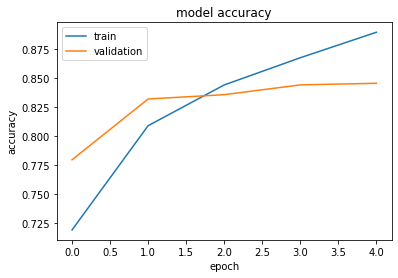

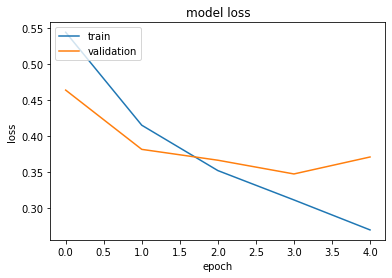

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [41]:
score=model.evaluate(x_test, y_test, verbose=0)

In [42]:
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))

accuracy: 83.40%
loss: 37.88%


## MODEL1-Bidirectional LSTM without using pre-trained GloVe word embeddings

In [43]:
model1 = Sequential()
model1.add(Embedding(num_words, embedding_size, input_length=maxlen,weights = [embedding_matrix],trainable=True))
model1.add(Bidirectional(LSTM(128)))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

In [44]:
model1.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [45]:
batch_size = 100
epochs = 5
history1=model1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 17093 samples, validate on 4274 samples
Epoch 1/5
17093/17093 [==============================] - 19s 1ms/sample - loss: 0.4771 - accuracy: 0.7618 - val_loss: 0.3743 - val_accuracy: 0.8336
Epoch 2/5
17093/17093 [==============================] - 16s 939us/sample - loss: 0.2854 - accuracy: 0.8835 - val_loss: 0.3460 - val_accuracy: 0.8556
Epoch 3/5
17093/17093 [==============================] - 16s 943us/sample - loss: 0.1943 - accuracy: 0.9262 - val_loss: 0.3347 - val_accuracy: 0.8641
Epoch 4/5
17093/17093 [==============================] - 16s 943us/sample - loss: 0.1314 - accuracy: 0.9530 - val_loss: 0.4185 - val_accuracy: 0.8615
Epoch 5/5
17093/17093 [==============================] - 16s 935us/sample - loss: 0.0914 - accuracy: 0.9682 - val_loss: 0.4711 - val_accuracy: 0.8561


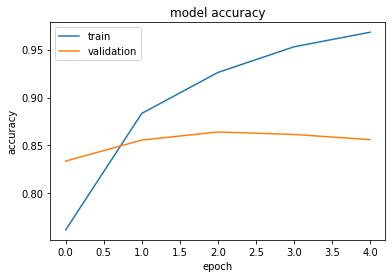

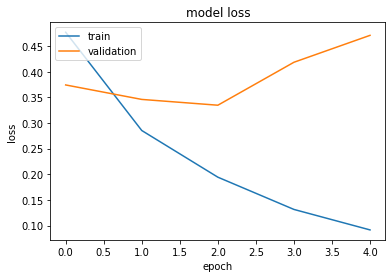

In [46]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [47]:
score1=model1.evaluate(x_test, y_test, verbose=0)

In [48]:
print("%s: %.2f%%" % (model.metrics_names[1], score1[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], score1[0]*100))

accuracy: 85.42%
loss: 46.20%


## MODEL2-Bidirectional LSTM with regularization

In [49]:
model2 = Sequential()
model2.add(Embedding(num_words, embedding_size, input_length=maxlen,weights = [embedding_matrix]))
model2.add(Bidirectional(LSTM(128,recurrent_dropout=0.5)))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

In [50]:
model2.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [51]:
batch_size = 100
epochs = 5
history2=model2.fit(x_train,y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 17093 samples, validate on 4274 samples
Epoch 1/5
17093/17093 [==============================] - 106s 6ms/sample - loss: 0.5023 - accuracy: 0.7463 - val_loss: 0.3776 - val_accuracy: 0.8348
Epoch 2/5
17093/17093 [==============================] - 101s 6ms/sample - loss: 0.3125 - accuracy: 0.8705 - val_loss: 0.3345 - val_accuracy: 0.8584
Epoch 3/5
17093/17093 [==============================] - 101s 6ms/sample - loss: 0.2860 - accuracy: 0.8840 - val_loss: 0.3612 - val_accuracy: 0.8510
Epoch 4/5
17093/17093 [==============================] - 101s 6ms/sample - loss: 0.1890 - accuracy: 0.9278 - val_loss: 0.3601 - val_accuracy: 0.8606
Epoch 5/5
17093/17093 [==============================] - 103s 6ms/sample - loss: 0.1398 - accuracy: 0.9496 - val_loss: 0.4153 - val_accuracy: 0.8514


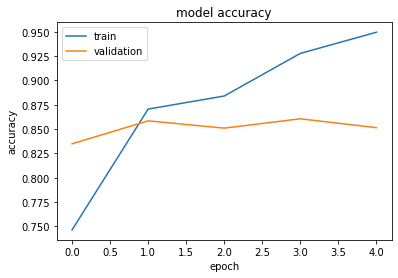

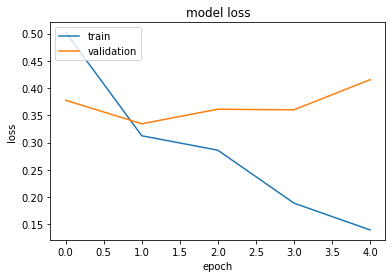

In [52]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [53]:
score2=model2.evaluate(x_test, y_test, verbose=0)

In [54]:
print("%s: %.2f%%" % (model.metrics_names[1], score2[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], score2[0]*100))

accuracy: 85.40%
loss: 41.76%


## MODEL3-Stacked Bidirectional LSTM

In [55]:
model3 = Sequential()
model3.add(Embedding(num_words, embedding_size, input_length=maxlen,weights = [embedding_matrix]))
model3.add(Bidirectional(LSTM(128, return_sequences = True)))
model3.add(Bidirectional(LSTM(128)))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

In [56]:
model3.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [57]:
batch_size = 100
epochs = 5
history3=model3.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Train on 17093 samples, validate on 4274 samples
Epoch 1/5
17093/17093 [==============================] - 33s 2ms/sample - loss: 0.4597 - accuracy: 0.7758 - val_loss: 0.3671 - val_accuracy: 0.8290
Epoch 2/5
17093/17093 [==============================] - 27s 2ms/sample - loss: 0.2674 - accuracy: 0.8902 - val_loss: 0.3434 - val_accuracy: 0.8624
Epoch 3/5
17093/17093 [==============================] - 28s 2ms/sample - loss: 0.1709 - accuracy: 0.9371 - val_loss: 0.3717 - val_accuracy: 0.8638
Epoch 4/5
17093/17093 [==============================] - 28s 2ms/sample - loss: 0.1037 - accuracy: 0.9635 - val_loss: 0.4409 - val_accuracy: 0.8524
Epoch 5/5
17093/17093 [==============================] - 28s 2ms/sample - loss: 0.0813 - accuracy: 0.9713 - val_loss: 0.4829 - val_accuracy: 0.8533


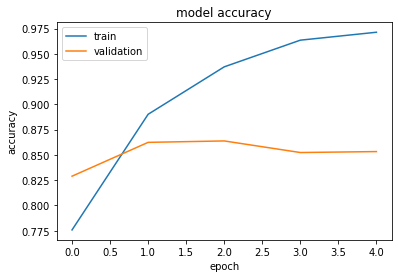

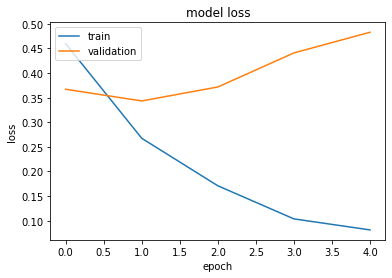

In [58]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [59]:
score3=model3.evaluate(x_test, y_test, verbose=0)

In [60]:
print("%s: %.2f%%" % (model.metrics_names[1], score3[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], score3[0]*100))

accuracy: 85.77%
loss: 47.63%


## Model comparsion

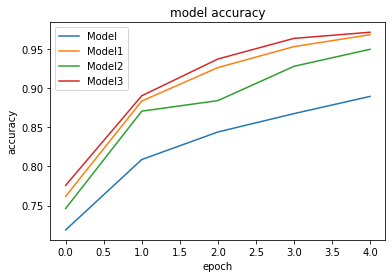

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history1.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Model','Model1','Model2','Model3'], loc='upper left')
plt.show()

## Model1 and Model3 seems to perform better , but Model3's accuracy is slightly better than Model1. Therefore, Model3 will be used to predict on test data.

### Prediction from best model

In [62]:
y_hat = model3.predict(x_test)

In [63]:
len(y_hat)

5342

In [64]:
len(y_test)

5342

In [65]:
y_pred=(list(np.round(y_hat)))

In [66]:
y_pred

[array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([1.], dtype=float32),
 array([1.], dtype=float32),
 array([0.], dtype=float32),
 array([0.], d

In [67]:
y_test

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

## Confusion Matrix

In [68]:
cm_pred = confusion_matrix(y_test,y_pred)

In [69]:
cm_pred

array([[2613,  383],
       [ 377, 1969]], dtype=int64)

## Classification Matrix

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2996
           1       0.84      0.84      0.84      2346

    accuracy                           0.86      5342
   macro avg       0.86      0.86      0.86      5342
weighted avg       0.86      0.86      0.86      5342



## Conclusion

## Among all the models, stacked Bidirectional LSTM gives the best accuracy to classify the headlines in term of sarcasm.